In [61]:
# !pip install rdkit
# !pip install lazypredict
# !pip install catboost
# !pip install shap

In [62]:
# import numpy as sns
# import pandas as np
# import seaborn as pd
# import matplotlib.pyplot as torch
# import catboost as plt

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, LearningCurveDisplay, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.nn import functional as F
 
device = torch.device('cpu')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from copy import deepcopy
import pickle

RANDOM_STATE = 42

# 1 | Загружаем все данные

In [63]:
df = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

# Имена категориальных и численных колонок 
num_cols = ['Drug_dose', 
            'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg', 
            'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP', 
            'fold_increase_in_antibacterial_activity (%)']

cat_cols = ['Bacteria', 'NP_Synthesis', 'Drug',	'Drug_class_drug_bank', 'shape', 'method', 'MDR_check']

df

Bacteria  \
0          Escherichia coli   
1          Escherichia coli   
2          Escherichia coli   
3          Escherichia coli   
4        Micrococcus luteus   
..                      ...   
878   Staphylococcus aureus   
879  Acinetobacter baumanii   
880   Enterococcus faecalis   
881   Enterococcus faecalis   
882   Enterococcus faecalis   

                                          NP_Synthesis         Drug  \
0                chem_synthesis_reduction_by_D_maltose  Amoxicillin   
1                chem_synthesis_reduction_by_D_maltose   Penicillin   
2                chem_synthesis_reduction_by_D_maltose  Amoxicillin   
3                chem_synthesis_reduction_by_D_maltose   Penicillin   
4      green_synthesis from fungus  Aspergillus flavus   Vancomycin   
..                                                 ...          ...   
878  green_synthesis using C. zylinicum aqueous ext...          NaN   
879  green_synthesis using C. zylinicum aqueous ext...          NaN   
880  green_synthesis using extract of Klebsiella pn...          NaN   
881  green_synthesis using extract of Klebsiella pn...          NaN   
882  green_synthesis using extract of Klebsiella pn...          NaN   

                 Drug_class_drug_bank  Drug_dose NP_concentration  \
0                             Lactams        NaN              NaN   
1    Carboxylic acids and derivatives        NaN              NaN   
2                             Lactams        NaN              NaN   
3    Carboxylic acids and derivatives        NaN              NaN   
4    Carboxylic acids and derivatives      30.00              100   
..                                ...        ...              ...   
878                               NaN        NaN              NaN   
879                               NaN        NaN              NaN   
880                               NaN        NaN               10   
881                               NaN        NaN               20   
882                               NaN        NaN               30   

     NP size_min  NP size_max  NP size_avg      shape          method  \
0           4.00        10.00         8.00  spherical             MIC   
1           4.00        10.00         8.00  spherical             MIC   
2          15.00        30.00        28.00  spherical             MIC   
3          15.00        30.00        28.00  spherical             MIC   
4           5.00        30.00        21.00  spherical  disc_diffusion   
..           ...          ...          ...        ...             ...   
878        10.00        78.90        44.45  spherical             MIC   
879        10.00        78.90        44.45  spherical             MIC   
880        20.00        20.00        20.00  spherical  disc_diffusion   
881        20.00        20.00        20.00  spherical  disc_diffusion   
882        20.00        20.00        20.00  spherical  disc_diffusion   

    ZOI_drug ZOI_NP ZOI_drug_NP  fold_increase_in_antibacterial_activity (%)  \
0        32+    6.3         32+                                          NaN   
1        32+    6.3         32+                                          NaN   
2        32+     25         32+                                          NaN   
3        32+     25         32+                                          NaN   
4          0     14        17+2                                         7.02   
..       ...    ...         ...                                          ...   
878      NaN    4.5         NaN                                          NaN   
879      NaN    5.7         NaN                                          NaN   
880      NaN     10         NaN                                          NaN   
881      NaN     18         NaN                                          NaN   
882      NaN     23         NaN                                          NaN   

     MDR_check  
0            1  
1            1  
2            1  
3            1  
4            1  
..         ...  
878    

# 2 | Предварительная обработка data

## Очистка и предварительный анализ численных признаков

Чистим от плюсиков.

In [64]:
df['ZOI_drug'] = df['ZOI_drug'].replace('32+', '32').astype('float64')
df['ZOI_drug'].unique()

array([3.200e+01, 0.000e+00, 1.200e+01, 5.000e+02, 2.200e+01, 4.600e+01,
       4.800e+01, 4.700e+01, 4.400e+01, 3.000e+01, 2.800e+01, 2.700e+01,
       4.000e+01, 2.300e+01, 2.500e+01, 3.400e+01, 2.600e+01, 3.700e+01,
       2.900e+01, 3.600e+01, 2.000e+01, 2.100e+01, 2.400e+01, 3.100e+01,
       1.000e+03, 2.500e+02, 8.000e+00, 1.400e+01, 1.700e+01, 1.800e+01,
       7.000e+00, 3.300e+01, 2.070e+01, 1.500e+01, 1.900e+01, 2.800e+00,
       1.100e+01, 1.300e+01, 1.600e+01, 1.730e+01, 1.850e+01, 9.000e+00,
       1.000e+01, 6.400e+01,       nan, 7.500e+00, 4.600e-01, 4.000e+00,
       1.000e+00, 2.000e+00, 1.250e+02, 1.250e+00, 6.250e-01, 3.125e-01,
       2.500e-01, 3.000e-02, 2.500e+00, 1.000e-02, 5.000e-02, 1.000e-01,
       5.000e-01, 7.500e-01, 1.280e+02])

In [65]:
df['ZOI_NP'] = df['ZOI_NP'].replace('50+', '50').astype('float64')
df['ZOI_NP'].unique()

array([6.300e+00, 2.500e+01, 1.400e+01,       nan, 1.500e+01, 1.300e+01,
       6.400e+01, 1.200e+01, 1.600e+01, 1.700e+01, 2.000e+01, 1.350e+01,
       2.100e+01, 1.900e+01, 1.000e+01, 2.400e+01, 1.800e+01, 2.200e+01,
       3.200e+01, 5.000e+01, 8.000e+00, 1.250e+01, 1.000e+02, 2.500e+00,
       5.000e+00, 4.000e+00, 1.100e+01, 5.000e-01, 2.500e-01, 2.000e+00,
       1.280e+02, 3.100e-01, 9.000e-02, 4.700e-01, 6.000e+01, 1.600e+02,
       1.800e+02, 2.200e+02, 4.000e+01, 1.200e+02, 1.400e+02, 0.000e+00,
       2.600e+01, 2.700e+01, 7.000e+00, 9.000e+00, 1.460e+01, 1.560e+01,
       1.730e+01, 2.030e+01, 7.800e+00, 8.100e+00, 9.800e+00, 3.000e+01,
       3.500e+01, 6.500e+01, 8.000e+01, 2.060e+01, 2.660e+01, 1.040e+00,
       2.000e-02, 4.000e+03, 1.055e+01, 1.122e+01, 1.139e+01, 1.157e+01,
       9.260e+00, 1.430e+01, 1.530e+01, 2.800e+00, 3.100e+00, 4.500e+00,
       5.700e+00, 2.300e+01])

In [66]:
df['ZOI_drug_NP'] = df['ZOI_drug_NP'].replace({'32+': '32', '17+2': '17'}).astype('float64')
df['ZOI_drug_NP'].unique()

array([3.200e+01, 1.700e+01, 1.500e+01, 6.250e+01, 5.000e+01, 4.800e+01,
       4.700e+01, 4.400e+01, 4.200e+01, 4.100e+01, 4.000e+01, 3.900e+01,
       3.800e+01, 3.700e+01, 3.600e+01, 3.500e+01, 3.400e+01, 3.125e+01,
       3.100e+01, 3.000e+01, 2.900e+01, 2.800e+01, 2.700e+01, 2.600e+01,
       2.500e+01, 2.400e+01, 2.300e+01, 2.200e+01, 2.150e+01, 2.100e+01,
       2.080e+01, 2.000e+01, 1.990e+01, 1.900e+01, 1.850e+01, 1.800e+01,
       1.600e+01, 1.530e+01, 1.475e+01, 1.433e+01, 1.400e+01, 1.300e+01,
       1.288e+01, 1.280e+01, 1.276e+01, 1.257e+01, 1.245e+01, 1.200e+01,
       1.167e+01, 1.164e+01, 1.145e+01, 1.143e+01, 1.100e+01, 1.098e+01,
       1.062e+01, 1.034e+01, 1.000e+01, 9.740e+00, 9.000e+00, 8.000e+00,
       7.810e+00, 7.000e+00, 4.800e+00, 4.000e+00, 2.000e+00, 1.750e+00,
       1.000e+00, 9.700e-01, 8.000e-01, 6.000e-01, 5.000e-01, 4.000e-01,
       3.000e-01, 2.500e-01, 1.250e-01, 1.000e-01, 3.000e-02, 0.000e+00,
             nan])

В столбце ```NP_concentration``` обнаружились записи, где сразу три числа

In [67]:
df['NP_concentration'].unique()

array([nan, '100', '30', '170/85/42.5', '170/85/42.33', '170/85/42.15',
       '170/85/42.24', '170/85/42.20', '170/85/42.11', '10',
       '170/85/42.27', '170/85/42.13', '170/85/42.34', '170/85/42.8',
       '170/85/42.32', '170/85/42.23', '170/85/42.12', '170/85/42.25',
       '170/85/42.10', '170/85/42.29', '170/85/42.26', '170/85/42.28',
       '170/85/42.16', '170/85/42.6', '170/85/42.31', '170/85/42.9',
       '170/85/42.19', '170/85/42.18', '170/85/42.30', '170/85/42.17',
       '170/85/42.21', '170/85/42.14', '20', '170/85/42.7',
       '170/85/42.22', '50', '25', '102', '104', '170', '85', '42.5',
       '21.25', '10.625', '2.65', '1.33', '0.66', '0.31', '1000', '500',
       '300'], dtype=object)

Проверим, что нет ничего особенного в строках с ними

In [68]:
df[df['NP_concentration'] == '170/85/42.29']

Bacteria                          NP_Synthesis      Drug  \
73  Salmonella enterica  green_synthesis using Ulva fasciata   Neomycin   

   Drug_class_drug_bank  Drug_dose NP_concentration  NP size_min  NP size_max  \
73                   NC      30.00     170/85/42.29        14.45        15.55   

    NP size_avg      shape          method  ZOI_drug  ZOI_NP  ZOI_drug_NP  \
73        15.00  spherical  disc_diffusion     14.00     NaN        28.00   

    fold_increase_in_antibacterial_activity (%)  MDR_check  
73                                          NaN          0

Возможно, это проведено три измерения с разными концентрациями НЧ, и в таргетные ячейки записано среднее. Добавим столбец "эксперимент с разными концентрациями": ```bool```.
Но проще просто выкинуть

In [69]:
'''df['various_conc_tested'] = np.array(['/' in str(x) for x in df['NP_concentration']])
df.loc[df['various_conc_tested'] == True, 'NP_concentration'] = 170
df['various_conc_tested'].value_counts()'''

df = df[~(df['NP_concentration'].astype(str).str.contains('170/85'))]
df['NP_concentration'] = df['NP_concentration'].astype('float64')

In [70]:
df['NP_concentration'].unique()

array([       nan, 1.0000e+02, 3.0000e+01, 1.0000e+01, 2.0000e+01,
       5.0000e+01, 2.5000e+01, 1.0200e+02, 1.0400e+02, 1.7000e+02,
       8.5000e+01, 4.2500e+01, 2.1250e+01, 1.0625e+01, 2.6500e+00,
       1.3300e+00, 6.6000e-01, 3.1000e-01, 1.0000e+03, 5.0000e+02,
       3.0000e+02])

Заменим NP size min/max на размах

In [71]:
df['min_max_NP_size'] = df['NP size_max'] - df['NP size_min']
df.drop(columns=['NP size_max', 'NP size_min'], inplace=True)

df.rename(columns={'NP size_avg': 'avg_NP_size'}, inplace=True)

num_cols.pop(num_cols.index('NP size_max'))
num_cols.pop(num_cols.index('NP size_min'))
num_cols.pop(num_cols.index('NP size_avg'))
num_cols.append('avg_NP_size')
num_cols.append('min_max_NP_size')

In [72]:
df.dtypes

Bacteria                                        object
NP_Synthesis                                    object
Drug                                            object
Drug_class_drug_bank                            object
Drug_dose                                      float64
NP_concentration                               float64
avg_NP_size                                    float64
shape                                           object
method                                          object
ZOI_drug                                       float64
ZOI_NP                                         float64
ZOI_drug_NP                                    float64
fold_increase_in_antibacterial_activity (%)    float64
MDR_check                                        int64
min_max_NP_size                                float64
dtype: object

Численные фичи в порядке

## Очистка и предварительный анализ строковых признаков

Ищем проблемы в строковых фичах:

In [73]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n')

Bacteria :
 ['Acinetobacter baumanii', 'Actinobacillus pleuropneumoniae ', 'Bacillus cereus', 'Bacillus spp.        ', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae ', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella  typhi', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhimurium ', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 

NP_Synthesis :
 ['chem_synthesis', 'chem_synthesis (purchased from Vector Vita Ltd, Novosibirsk, 

0) Куча лишних пробелов, нужен ```str.strip```

In [74]:
# strip на все строки, drug с маленькой буквы, чтобы унифицировать
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

1) Bacteria: слишком много опечаток

In [75]:
df['Bacteria'] = df['Bacteria'].replace({
    'Acinetobacter baumanii': 'Acinetobacter baumannii',
    'Bacillus spp.': 'Bacillus sp.',
    'Salmonella  typhi': 'Salmonella typhi'
})

2) NP_Synthesis: куча лишней инфы, скорее всего окажется важным зеленый/химический синтез, и то не факт

In [76]:
df['NP_Synthesis'] = df['NP_Synthesis'].replace({'chem_synthesis.*': 'chem_synthesis', 
                                                 'chemical_synthesis.*': 'chem_synthesis',
                                                 'green_synthesis.*': 'green_synthesis'}, regex=True)

3) Drug: некоторые написаны с маленькой буквы

In [77]:
df['Drug'] = df['Drug'].map(lambda x: x.lower() if isinstance(x, str) else x)

4) Drug_class_drug_bank: есть два drug'a, которые отнесены к двум классам сразу. Посмотрели глазами, решили, что можно оставить один класс, потеряем не много

In [78]:
print(df[df['Drug_class_drug_bank'] == 'Benzene and substituted derivatives; Phenol ethers'])
df['Drug_class_drug_bank'] = df['Drug_class_drug_bank'].replace('Benzene and substituted derivatives; Phenol ethers', 'Benzene and substituted derivatives')

                 Bacteria     NP_Synthesis            Drug  \
26       Escherichia coli  green_synthesis  co-trimoxazole   
31  Staphylococcus aureus  green_synthesis  co-trimoxazole   

                                 Drug_class_drug_bank  Drug_dose  \
26  Benzene and substituted derivatives; Phenol et...       2.00   
31  Benzene and substituted derivatives; Phenol et...       2.00   

    NP_concentration  avg_NP_size      shape          method  ZOI_drug  \
26             10.00        22.50  spherical  disc_diffusion     37.00   
31             10.00        22.50  spherical  disc_diffusion     36.00   

    ZOI_NP  ZOI_drug_NP  fold_increase_in_antibacterial_activity (%)  \
26     NaN        37.00                                         0.00   
31     NaN        36.00                                         0.00   

    MDR_check  min_max_NP_size  
26          0            27.00  
31          0            27.00  


Теперь все хорошо

In [79]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n', len(sorted(df[i].dropna().unique().tolist())))

Bacteria :
 ['Acinetobacter baumannii', 'Actinobacillus pleuropneumoniae', 'Bacillus cereus', 'Bacillus sp.', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhi', 'Salmonella typhimurium', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 
 38
NP_Synthesis :
 ['chem_synthesis', 'green_synthesis'] 
 2
Drug :
 ['amikacin', 'amoxicillin', 'amphoterici

## Избавляемся от NaN

In [80]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 241
Drug_class_drug_bank - nans: 241
Drug_dose - nans: 306
NP_concentration - nans: 250
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 256
ZOI_NP - nans: 412
ZOI_drug_NP - nans: 299
fold_increase_in_antibacterial_activity (%) - nans: 432
MDR_check - nans: 0
min_max_NP_size - nans: 0


### ```ZOI_drug_NP```
target, вынуждены выбросить, остается 584 сэмпла

In [81]:
df = df[~df['ZOI_drug_NP'].isna()]
print('Remaining rows:', df.shape[0])

Remaining rows: 554


### ```Drug_dose```
Смотрим на значения, там сильный разброс, но явно есть порядки 1, 10 и 100, поэтому заменим его на логарифм, а для нанов применим KNN

In [82]:
df['Drug_dose'].unique()

array([  nan,  30. ,  10. , 500. ,   2. ,   5. , 100. , 300. ,  25. ,
        20. ,  50. ,   2.5,  15. ])

In [83]:
df['lg_Drug_dose'] = np.log10(df['Drug_dose'])
df.drop(columns=['Drug_dose'], inplace=True)

In [84]:
num_cols.pop(num_cols.index('Drug_dose'))
num_cols.append('lg_Drug_dose')

In [85]:
df['lg_Drug_dose'].unique()

array([       nan, 1.47712125, 1.        , 2.69897   , 0.30103   ,
       0.69897   , 2.        , 2.47712125, 1.39794001, 1.30103   ,
       1.69897   , 0.39794001, 1.17609126])

### ```NP_concentration``` 
вот такая гистограмма, можно заменить на моду.

<Axes: xlabel='NP_concentration', ylabel='Probability'>

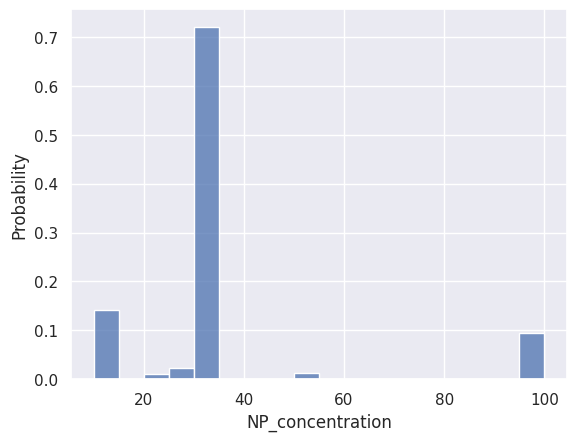

In [86]:
sns.histplot(df['NP_concentration'].dropna().astype('float32'), stat='probability', binwidth=5)

In [87]:
mode_conc = df['NP_concentration'].mode()[0]
df['NP_concentration'].fillna(mode_conc, inplace=True)
df['NP_concentration']

0      30.00
1      30.00
2      30.00
3      30.00
4     100.00
       ...  
579    30.00
580    30.00
581    30.00
582    30.00
583    30.00
Name: NP_concentration, Length: 554, dtype: float64

### ```ZOI_NP```
422/583 NaN, разумнее будет выкинуть, не глядя на распределение и важность и ни о чем не жалея

In [88]:
df.drop(columns=['ZOI_NP'], inplace=True)
num_cols.pop(num_cols.index('ZOI_NP'))

'ZOI_NP'

###  ```ZOI_drug```
Заменим по KNN, обучив на свойствах соответствующих лекарств и бактерий. Поскольку про них все известно, должно получиться хорошо.

### ```fold_increase_in_antibacterial_activity (%)```
Также используем KNN для заполнения пропусков.

Применять KNN будем после объединения баз данных. 

In [89]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')
print('--------------\nRows:', df.shape[0])

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 0
Drug_class_drug_bank - nans: 0
NP_concentration - nans: 0
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 15
ZOI_drug_NP - nans: 0
fold_increase_in_antibacterial_activity (%) - nans: 133
MDR_check - nans: 0
min_max_NP_size - nans: 0
lg_Drug_dose - nans: 119
--------------
Rows: 554


# 3 | Предварительная обработка drug_descriptors 

In [90]:
# Выкидываем, не понадобится: есть смайлс
df_drug.drop(columns=['prefered_name', 'chemID'], inplace=True)

# Все с маленькой буквы, strip на строки для очистки
df_drug = df_drug.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_drug['drug'] = df_drug['drug'].map(lambda x: x.lower() if isinstance(x, str) else x)
df_drug = df_drug.rename(columns={'drug': 'Drug', 'smiles': 'Smiles'})

# Откуда-то взялись дубликаты, выкидываем не думая
df_drug.drop_duplicates(inplace=True)
df_drug = df_drug.reset_index(drop=True)

Проверяем, что в БД drug есть все вещества, какие есть в data

In [91]:
drugs_in_drugs = set(df_drug.Drug.unique())
drugs_in_data = set(df.Drug.unique())
drugs_in_data.difference(drugs_in_drugs)

{'neomycin'}

Не хватает неомицина, добавим его вручную (SMILES с учетом хиральности из PubChem)

In [92]:
Neomycin = {
    'Drug': ['neomycin'],
    'Smiles': [
        'C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CN)O)O)N)O[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O[C@@H]4[C@@H]([C@H]([C@@H]([C@@H](O4)CN)O)O)N)O)O)N'
    ]
}
row_to_append = pd.DataFrame(Neomycin)
df_drug = pd.concat([row_to_append, df_drug]).reset_index(drop=True)

## Подгрузка дополнительных признаков
 1. pKa: вычисляли с помощью J. Chem. Inf. Mod. 61(1) http://dx.doi.org/10.1021/acs.jcim.1c00075 - нейросеть, ее валидация R^2 0.75-0.95 в зависимости от основности/кислотности молекулы 

In [93]:
pKa = pd.read_csv('pKa.csv', sep=';')
pKa['Name'] = pKa['Name'].map(lambda x: x.lower() if isinstance(x, str) else x)

df_drug = pd.merge(df_drug, pKa, left_on='Drug', right_on='Name').drop(columns=['Name'])

2. Пишем функцию, чтобы легко добавлять дескрипторы из RDKit

In [94]:
def add_desc_to_df(df: pd.DataFrame, desc: list):
    '''
    Add column with descriptors values to df
    
    Parameters
    ----------
    df: pd.DataFrame

    desc: list[str]
    '''

    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['Smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)

Добавляем дескрипторы, см. ```descs_to_add```.
Почитали статьи про действие антибиотиков: 

In [95]:
descs_to_add = [
    'LabuteASA', 'NumHDonors', 'NumHAcceptors', 
    'MolLogP', 'MolWt', 'Chi0', 'RingCount', 'TPSA',
    'NumAliphaticRings', 'NumAromaticRings', 'NumAromaticHeterocycles',
    'MinPartialCharge', 'MaxPartialCharge', 'BertzCT'
]

df_drug = add_desc_to_df(df_drug, descs_to_add)

# 4 | Предварительная обработка bacterial_descriptors

Ищем бактерии, отсутствующие в df_bac и присутствующие в data

In [96]:
df_bac = df_bac.applymap(lambda x: x.strip() if isinstance(x, str) else x)
print(set(df['Bacteria'].unique()) - set(df_bac['Bacteria'].unique()))

# всего три строки с ними, дропаем
print(df[(df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi')].shape)
df = df[~((df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi'))]

{'Salmonella Paratyphi', 'Candida glochares'}
(3, 14)


Обнаружилась неправильно названная бактерия, первая (90371) гуглится, вызывает тиф и является сальмонеллой, а вторая (615) даже не сальмонелла, гуглим и переименовываем

In [97]:
df_bac[df_bac.duplicated(subset='Bacteria', keep=False)]

Bacteria   kingdom subkingdom clade          phylum  \
Tax_id                                                                         
['90371']  Salmonella typhimurium  Bacteria        NaN   NaN  Pseudomonadota   
['615']    Salmonella typhimurium  Bacteria        NaN   NaN  Pseudomonadota   

                         class             order              family  \
Tax_id                                                                 
['90371']  Gammaproteobacteria  Enterobacterales  Enterobacteriaceae   
['615']    Gammaproteobacteria  Enterobacterales        Yersiniaceae   

                genus              species gram  min_Incub_period, h  \
Tax_id                                                                 
['90371']  Salmonella  Salmonella enterica    n                 6.00   
['615']      Serratia  Serratia marcescens    n                 2.00   

           avg_Incub_period, h  max_Incub_period, h  growth_temp, C  \
Tax_id                                                                
['90371']                39.00                72.00              37   
['615']                   7.00                12.00              30   

           biosafety_level isolated_from  
Tax_id                                    
['90371']                2          meat  
['615']                  2         water

In [98]:
df_bac.loc["['615']", 'Bacteria'] = 'Serratia marcescens'

Оставляем только тех бактерий, которые есть в data

In [99]:
df_bac = df_bac[df_bac['Bacteria'].isin(df['Bacteria'].unique())]

## Избавляемся от NaN

In [100]:
print(df_bac.shape)
for col in df_bac:
    print(f'{col} - nans: {df_bac[col].isna().sum()}')

(32, 17)
Bacteria - nans: 0
kingdom - nans: 0
subkingdom - nans: 29
clade - nans: 20
phylum - nans: 0
class - nans: 0
order - nans: 0
family - nans: 0
genus - nans: 0
species - nans: 0
gram - nans: 3
min_Incub_period, h - nans: 1
avg_Incub_period, h - nans: 0
max_Incub_period, h - nans: 1
growth_temp, C - nans: 0
biosafety_level - nans: 0
isolated_from - nans: 0


Столбцы ```subkingom``` и ```clade``` дропаем из-за пропусков

In [101]:
df_bac.drop(columns=['subkingdom', 'clade'], inplace=True)

```gram```: заполним nan согласно NCBI - базе данных с бактериями

In [102]:
df_bac[df_bac.gram.isna()]

Bacteria kingdom      phylum            class  \
Tax_id                                                             
['5476']   Candida albicans   Fungi  Ascomycota  Saccharomycetes   
['5478']   Candida glabrata   Fungi  Ascomycota  Saccharomycetes   
['45582']  Candida saitoana   Fungi  Ascomycota  Saccharomycetes   

                       order              family             genus  \
Tax_id                                                               
['5476']   Saccharomycetales   Debaryomycetaceae           Candida   
['5478']   Saccharomycetales  Saccharomycetaceae      Nakaseomyces   
['45582']  Saccharomycetales   Debaryomycetaceae  Candida glaebosa   

                    species gram  min_Incub_period, h  avg_Incub_period, h  \
Tax_id                                                                       
['5476']   Candida albicans  NaN                48.00                84.00   
['5478']   Candida glabrata  NaN                24.00                36.00   
['45582']  Candida saitoana  NaN                48.00                84.00   

           max_Incub_period, h  growth_temp, C  biosafety_level isolated_from  
Tax_id                                                                         
['5476']                120.00              37                2         mouth  
['5478']                 48.00              37                2         blood  
['45582']               120.00              37                1          food

In [103]:
df_bac.loc[df_bac.gram.isna(), 'gram'] = 'p'

```min/max_Incub_period```: Заполним nan и некорректные значение модой

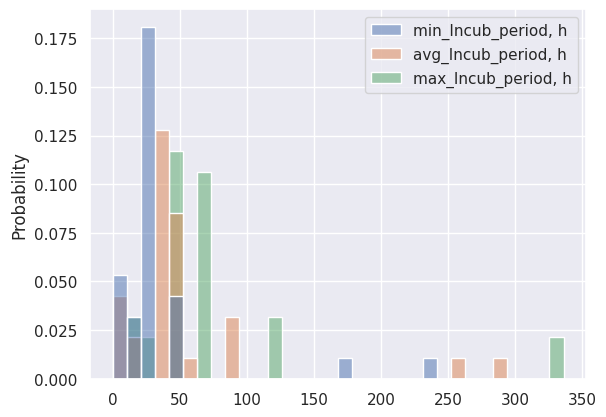

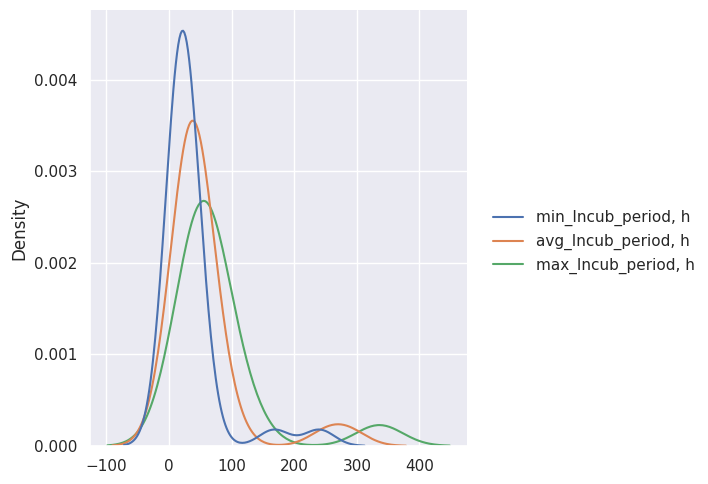

In [104]:
sns.histplot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], stat='probability')

sns.displot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], kind='kde')

In [105]:
df_bac[df_bac['min_Incub_period, h'].isna()]

Bacteria   kingdom          phylum                class  \
Tax_id                                                                       
['618']  Serratia odorifera  Bacteria  Pseudomonadota  Gammaproteobacteria   

                    order        family     genus             species gram  \
Tax_id                                                                       
['618']  Enterobacterales  Yersiniaceae  Serratia  Serratia odorifera    n   

         min_Incub_period, h  avg_Incub_period, h  max_Incub_period, h  \
Tax_id                                                                   
['618']                  NaN                 0.00                  NaN   

         growth_temp, C  biosafety_level isolated_from  
Tax_id                                                  
['618']              30                1          soil

In [106]:
df_bac.loc[df_bac['min_Incub_period, h'].isna(), 'min_Incub_period, h'] = df_bac['min_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['max_Incub_period, h'].isna(), 'max_Incub_period, h'] = df_bac['max_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['avg_Incub_period, h'].isna(), 'avg_Incub_period, h'] = df_bac['avg_Incub_period, h'].mode()[0]

## Думаем над фичами

1. Три коррелирующих числа (min max и avg время инкубации) нам ни к чему, но можно посчитать "размах" - вдруг он окажется полезным

In [107]:
df_bac['min_max_Incub_period'] = df_bac['max_Incub_period, h'] - df_bac['min_Incub_period, h']
df_bac.drop(columns=['max_Incub_period, h', 'min_Incub_period, h'], inplace=True)
df_bac = df_bac.rename(columns={'avg_Incub_period, h': 'avg_Incub_period'})

Обнаружилась корреляция ```min_max_Incub_period``` с ```avg_Incub_period```, но график выглядит не так уж страшно линейным, поэтому попробуем.

<Axes: >

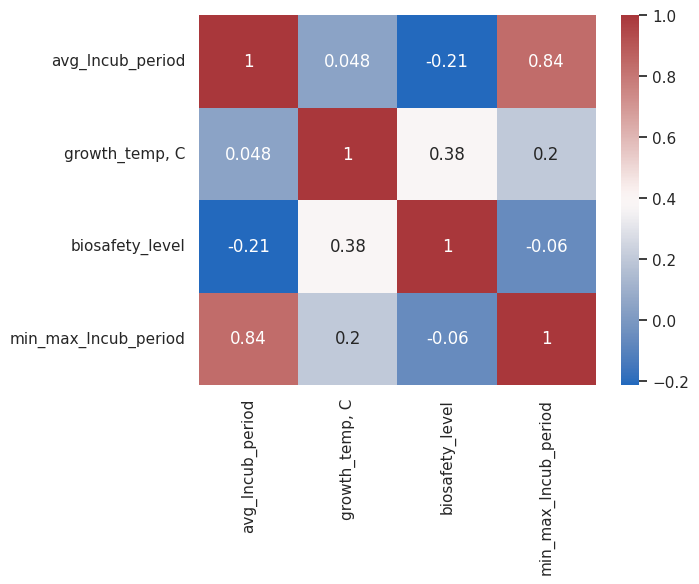

In [108]:
sns.heatmap(df_bac.corr(numeric_only=True), annot=True, cmap='vlag')

размах имеет слишком большую кореляцию, придется выкинуть :(

In [109]:
df_bac.drop(columns=['min_max_Incub_period'], inplace=True)

# 5 | Слияние трех баз данных в одну

In [110]:
df.drop_duplicates(inplace=True)
print(df.shape)

df = df.merge(df_bac, on='Bacteria', how='left')

df = df.merge(df_drug, on='Drug', how='left')

df.drop_duplicates(inplace=True)
print(df.shape)

(547, 14)
(547, 42)


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 546
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     547 non-null    object 
 1   NP_Synthesis                                 547 non-null    object 
 2   Drug                                         547 non-null    object 
 3   Drug_class_drug_bank                         547 non-null    object 
 4   NP_concentration                             547 non-null    float64
 5   avg_NP_size                                  547 non-null    float64
 6   shape                                        547 non-null    object 
 7   method                                       547 non-null    object 
 8   ZOI_drug                                     533 non-null    float64
 9   ZOI_drug_NP                                  547 non-null    float64
 10  fo

# 6 | Добиваем NaNы

Для оставшихся (столбцы ```ZOI_drug, fold_increase.., lg_Drug_dose ```) применяем KNN, обучая его по всей таблице, за исключением систематики бактерий и класса препарата (слишком много лишних столбцов с учетом encoding).

Создадим дополнительную таблицу для обучения KNN

In [112]:
cols_to_drop = [
    'isolated_from', 'Smiles', 'species', 'genus', 'family', 'order', 'class',
    'phylum', 'kingdom', 'Drug_class_drug_bank'
]

df_dummy = deepcopy(df)
df_dummy = df_dummy.drop(columns=cols_to_drop)

df_dummy = pd.get_dummies(df_dummy, drop_first=True)

In [113]:
imp = KNNImputer()
df_dummy = imp.fit_transform(df_dummy)

df_dummy = pd.DataFrame(df_dummy, columns=imp.get_feature_names_out())

In [114]:
f'Total NaNs: {df_dummy.isna().sum().sum()}'

'Total NaNs: 0'

Пока что будем работать с df_dummy

# 7 | Выбросы, корреляции и анализ 

In [115]:
num_cols_final = deepcopy(num_cols)
num_cols_final.extend(descs_to_add)
num_cols_final.append('pKa')

<Axes: >

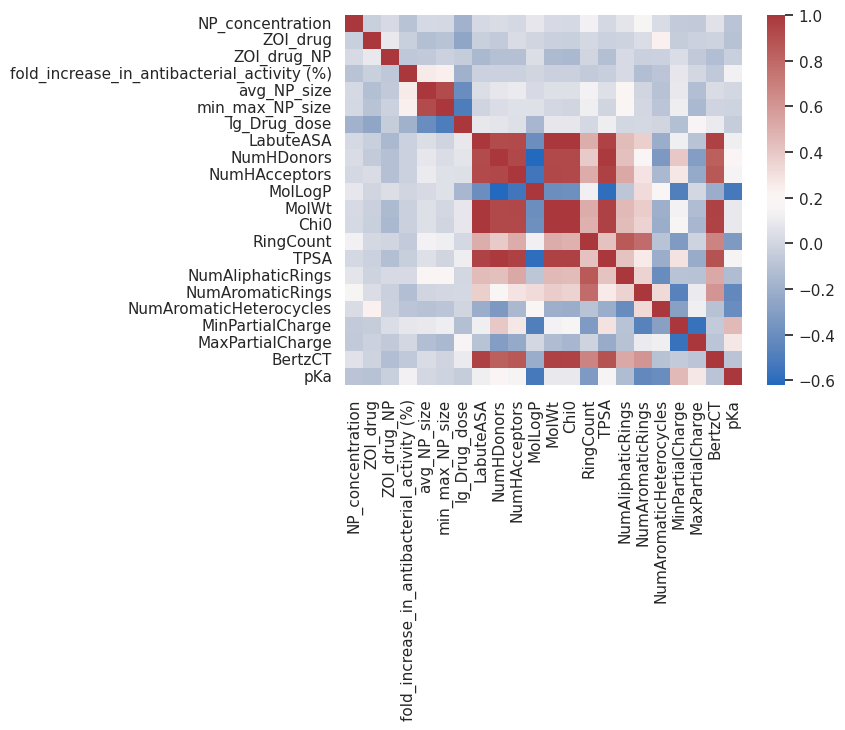

In [116]:
sns.heatmap(df_dummy[num_cols_final].corr(), cmap='vlag')
# df_dummy[num_cols_final].corr()[df_dummy[num_cols_final].corr() > 0.7]

--------------------------------! Внимание, медленная ячейка !-----------------------------

Сильно коррелируют столбцы дескрипторов, которые мы подгрузили, и размах размера нч со средним.  
Перестарались, отменяем :)

In [117]:
last_drop = ['LabuteASA', 'MolWt', 'Chi0', 'NumHDonors', 'TPSA', 'min_max_NP_size']
df_dummy.drop(columns=last_drop, inplace=True)
df.drop(columns=last_drop, inplace=True)
for col in last_drop:
    num_cols_final.remove(col)

<Axes: >

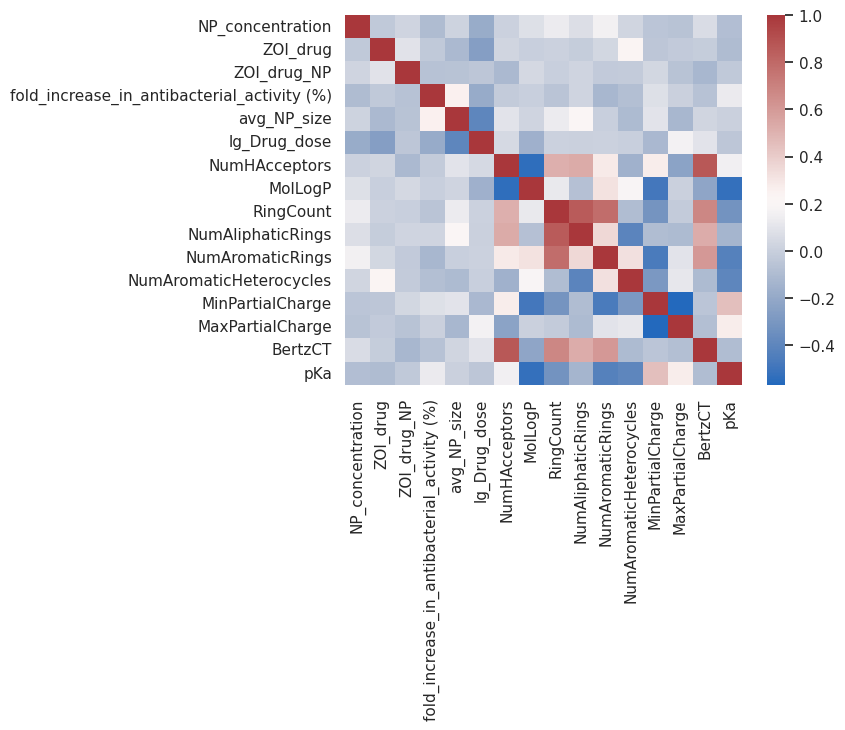

In [118]:
sns.heatmap(df_dummy[num_cols_final].corr(), cmap='vlag')

Красота! Остается посмотреть на распределения и pairplot

In [119]:
'''plot = sns.pairplot(df_dummy[num_cols_final], diag_kind='kde')
# plot.savefig('pairplot.png')'''

"plot = sns.pairplot(df_dummy[num_cols_final], diag_kind='kde')\n# plot.savefig('pairplot.png')"

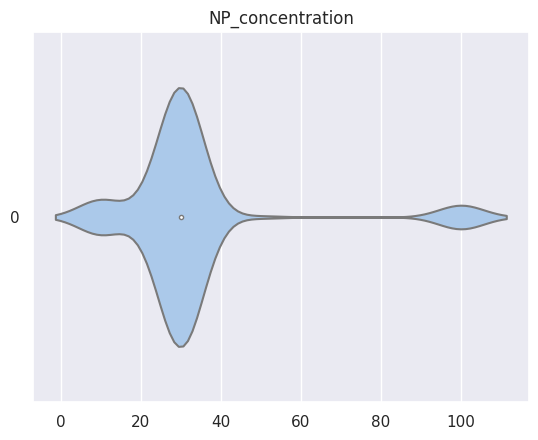

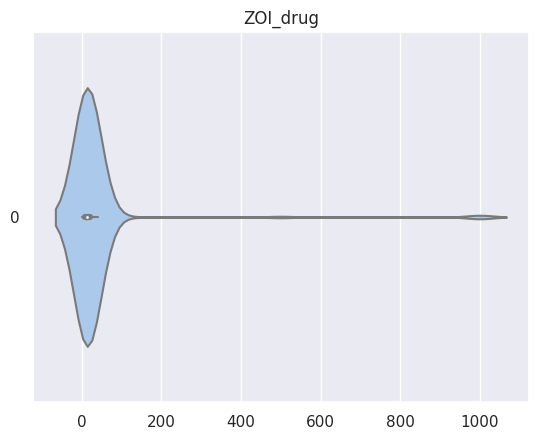

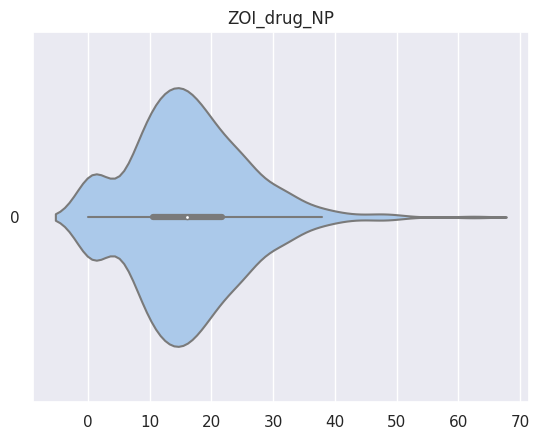

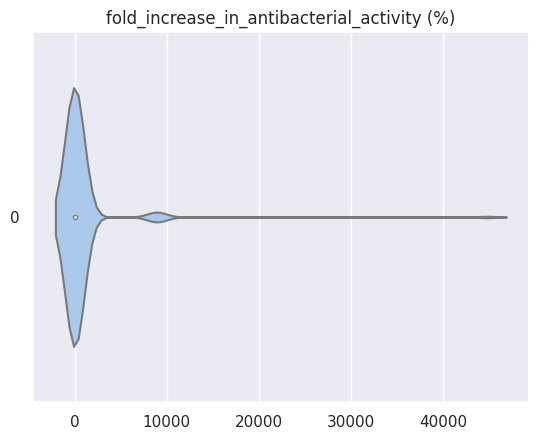

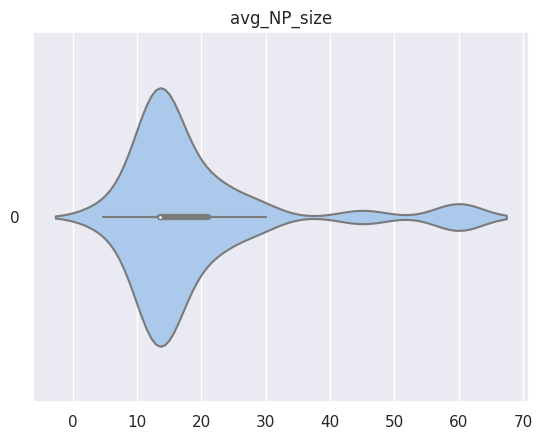

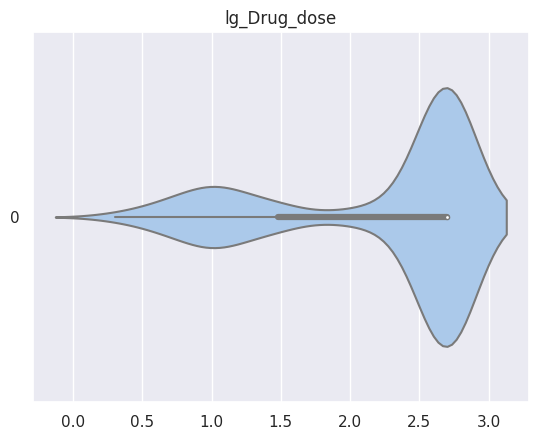

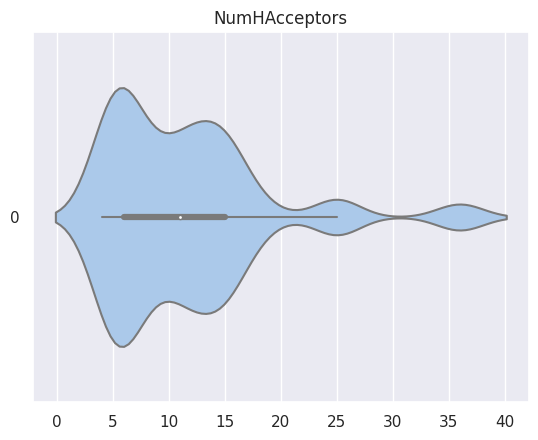

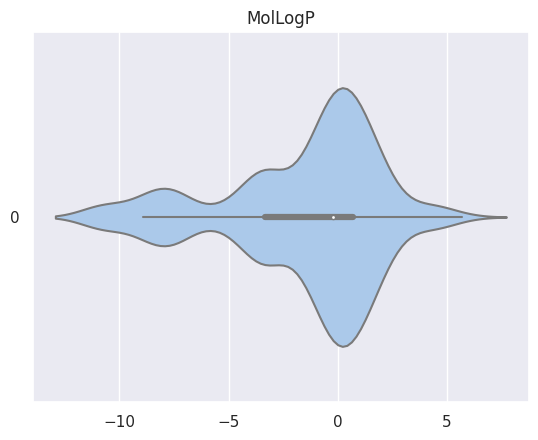

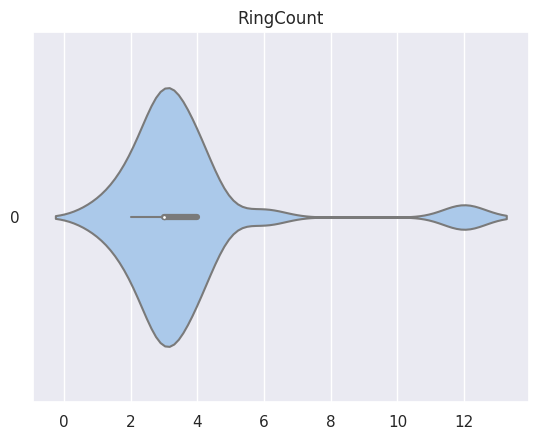

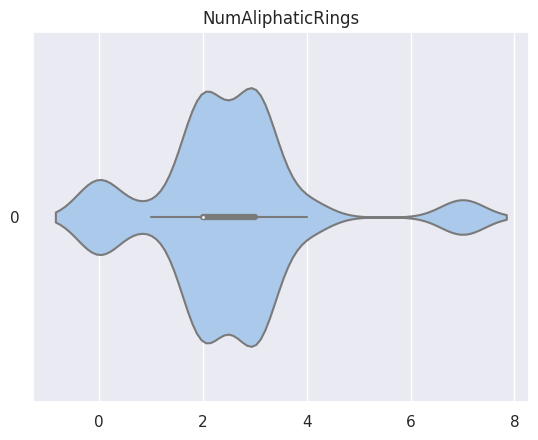

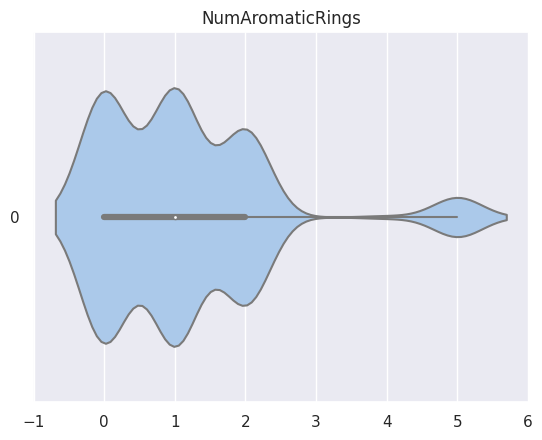

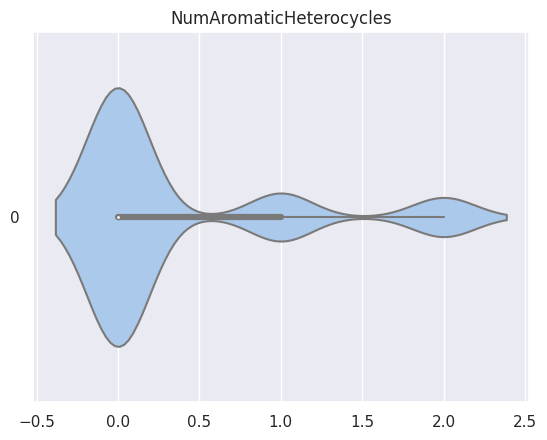

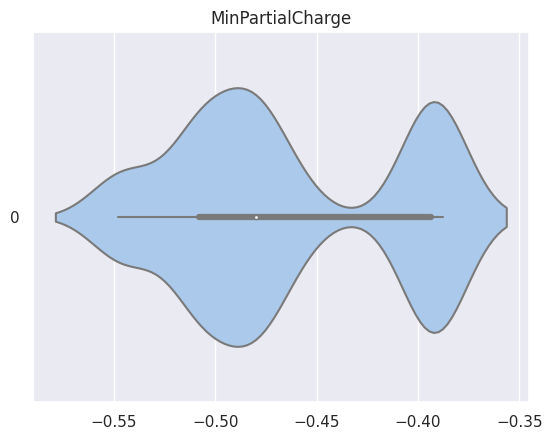

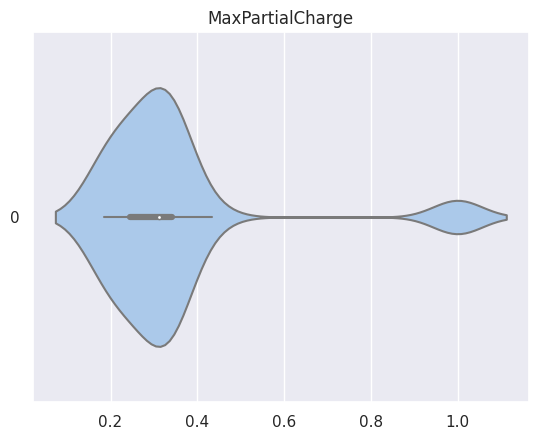

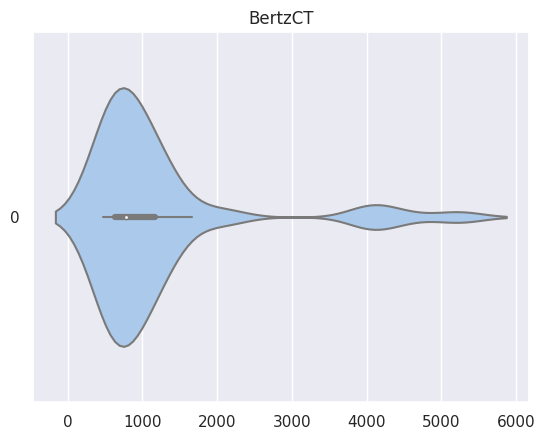

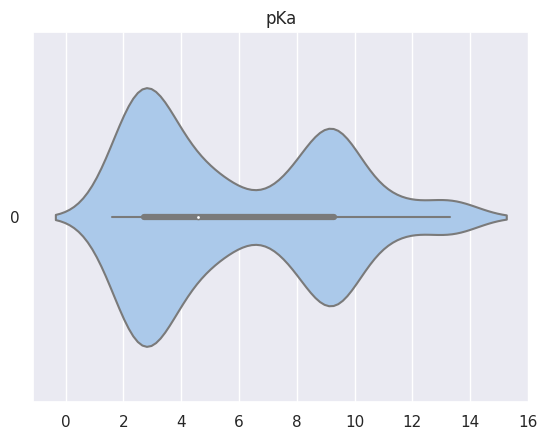

In [120]:
for col in num_cols_final:
    sns.violinplot(df_dummy[col], orient='h', width=0.7, palette='pastel')
    plt.title(col)
    plt.show()

Что-то странное с ```fold_increase``` и ```ZOI_drug```

In [121]:
for col, thresh in zip(['fold_increase_in_antibacterial_activity (%)', 'ZOI_drug'], [12, 80]):
    print(f'Column {col}, above {thresh}: {df_dummy[df_dummy[col] > thresh].shape[0]}')
    _med = df_dummy[col].median()
    df_dummy.loc[df_dummy[col] > thresh, col] = _med
    assert df_dummy[df_dummy[col] > thresh].shape[0] == 0

Column fold_increase_in_antibacterial_activity (%), above 12: 24
Column ZOI_drug, above 80: 12


Очистка данных закончена! Переносим в ```df``` столбцы, в которых мы заполняли дырки KNN-ом:

In [122]:
cols_to_fill = ['ZOI_drug', 'fold_increase_in_antibacterial_activity (%)', 'lg_Drug_dose']
df.loc[:, cols_to_fill] = df_dummy[cols_to_fill]
df.isna().sum().sum()

0

Теперь можно посмотреть на распределения категориальных признаков

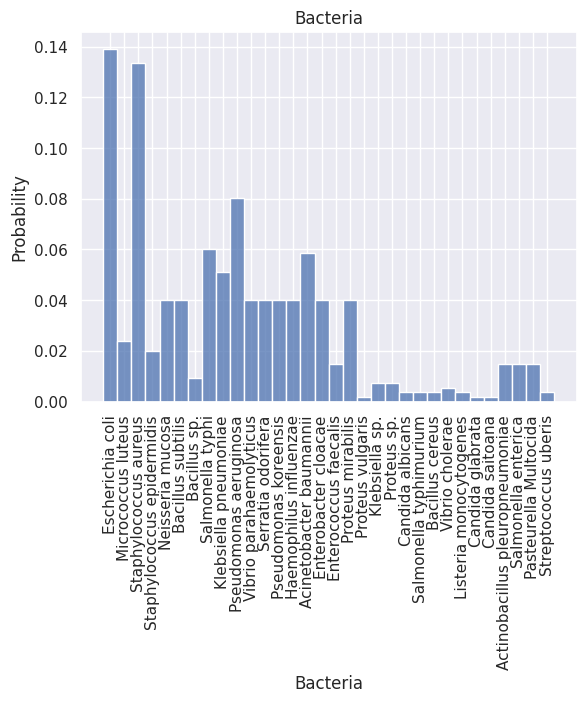

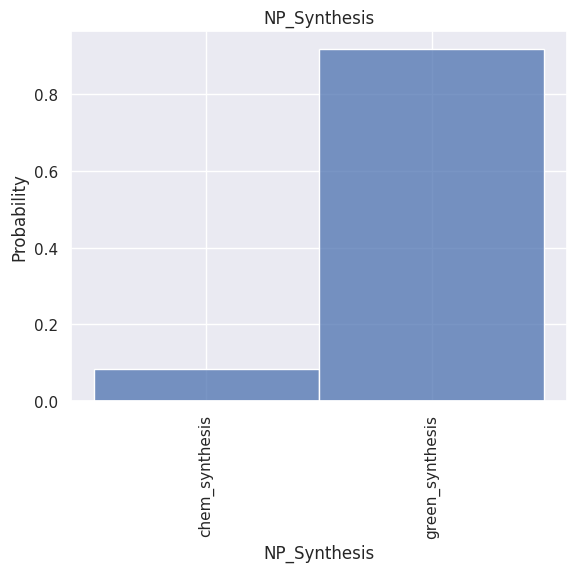

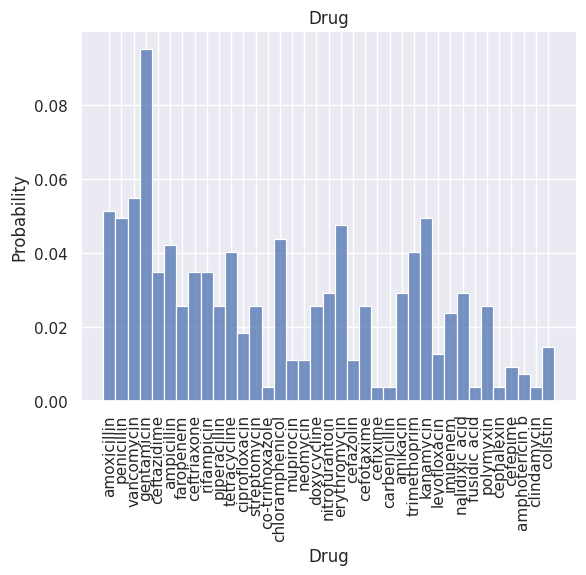

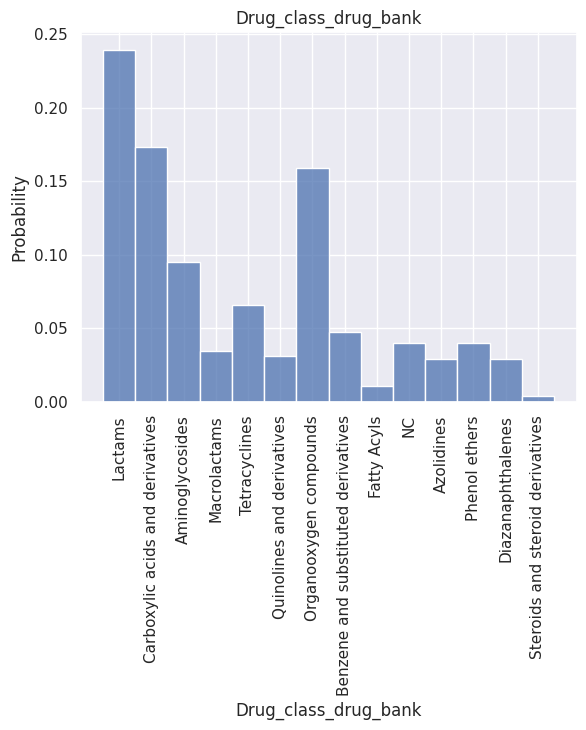

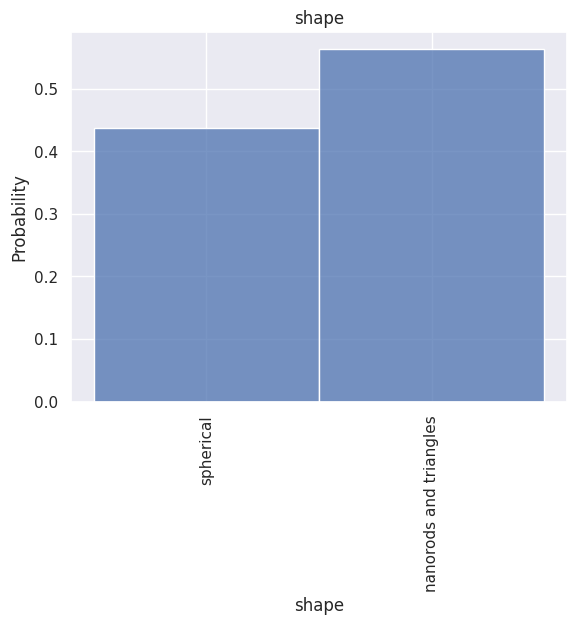

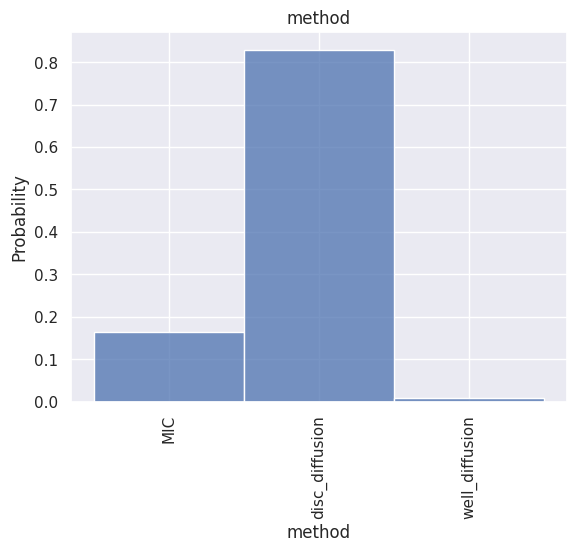

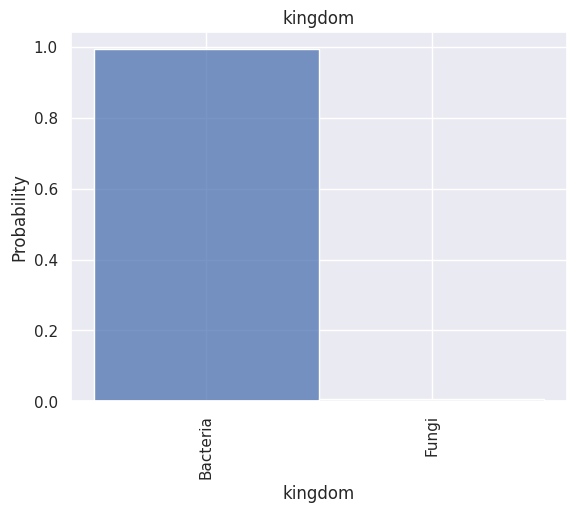

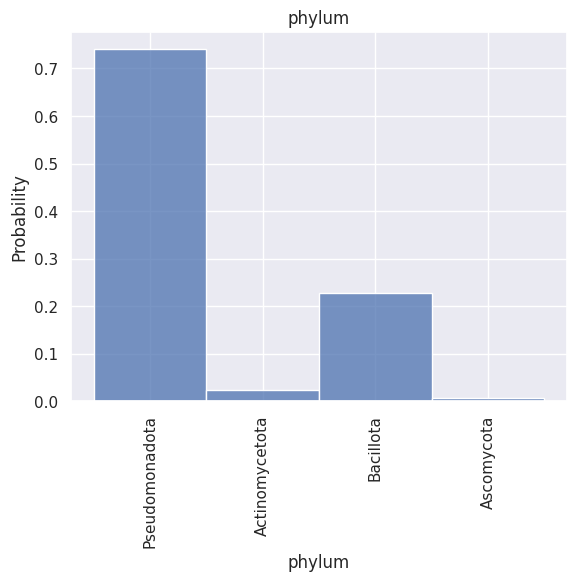

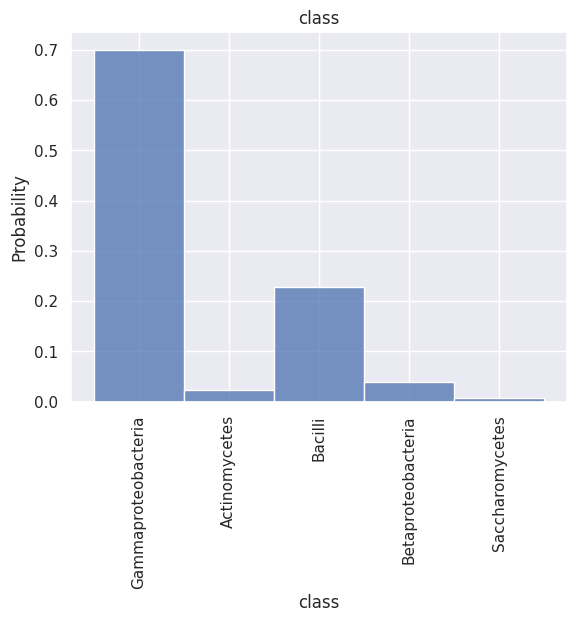

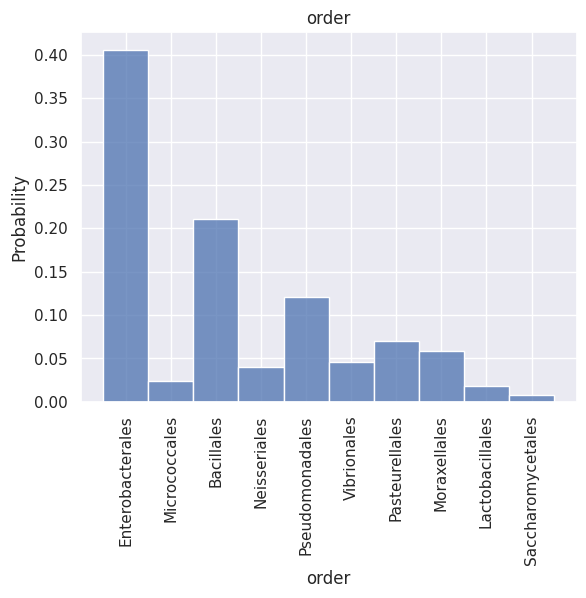

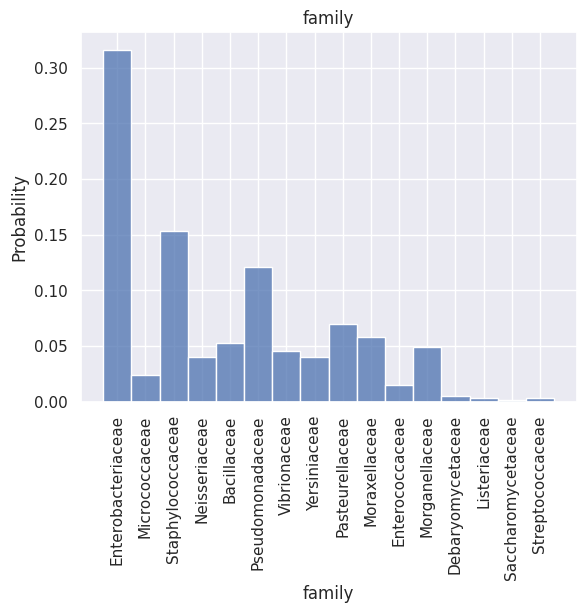

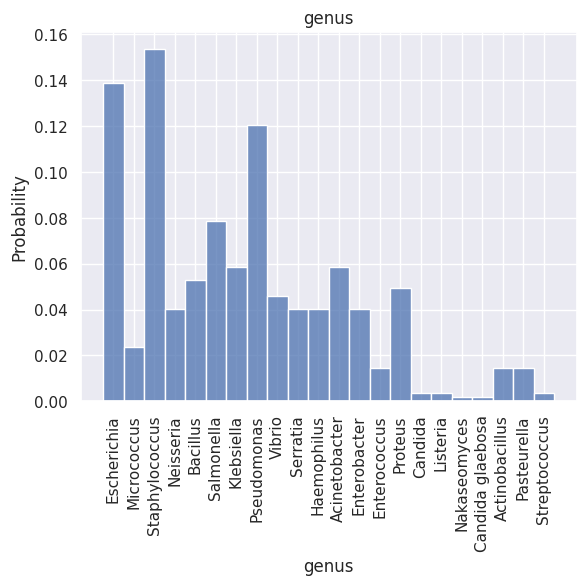

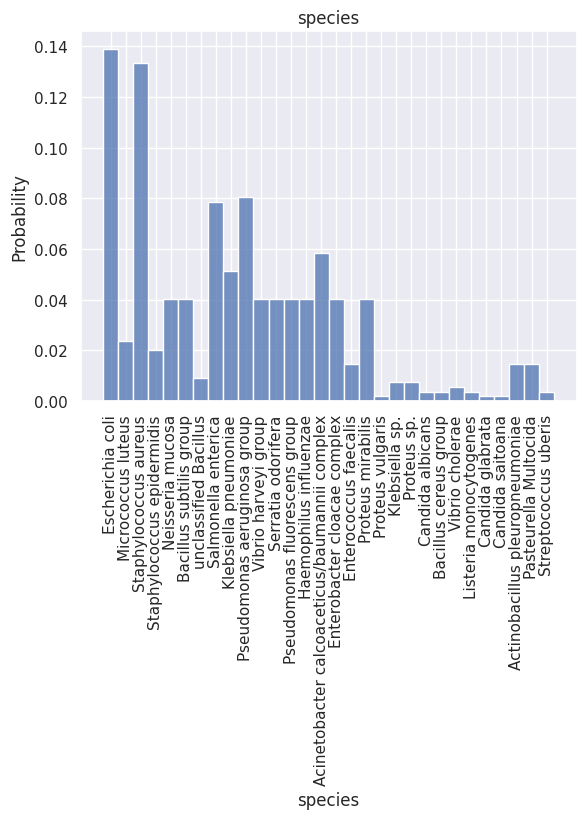

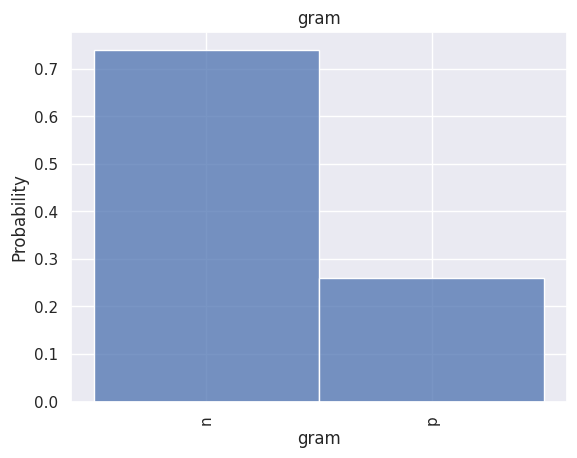

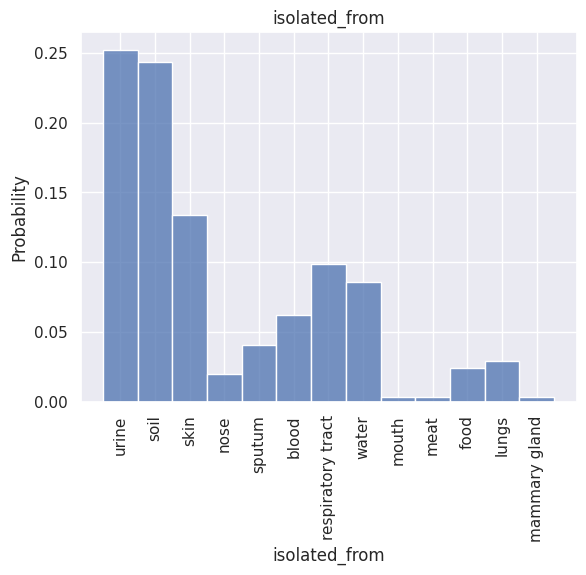

In [123]:
cat_cols = [i for i in df.drop(columns=['Smiles']).columns if df[i].dtype == object]
for col in cat_cols:
    sns.histplot(df[col], stat='probability')
    plt.title(col)
    plt.tick_params(axis='x', rotation=90)
    plt.show()

Классы не сбалансированы (напр., мы по нашему датасету никогда не научимся предсказывать для грибов (Fungi), поскольку их оч мало). Но не до жиру, дропать ничего не будем

Сохраним чистые данные в отдельный файл

In [124]:
df.drop(columns=['Smiles']).to_csv('clean_data.csv')

In [125]:
df.drop(columns=['Smiles']).columns

Index(['Bacteria', 'NP_Synthesis', 'Drug', 'Drug_class_drug_bank',
       'NP_concentration', 'avg_NP_size', 'shape', 'method', 'ZOI_drug',
       'ZOI_drug_NP', 'fold_increase_in_antibacterial_activity (%)',
       'MDR_check', 'lg_Drug_dose', 'kingdom', 'phylum', 'class', 'order',
       'family', 'genus', 'species', 'gram', 'avg_Incub_period',
       'growth_temp, C', 'biosafety_level', 'isolated_from', 'pKa',
       'NumHAcceptors', 'MolLogP', 'RingCount', 'NumAliphaticRings',
       'NumAromaticRings', 'NumAromaticHeterocycles', 'MinPartialCharge',
       'MaxPartialCharge', 'BertzCT'],
      dtype='object')

# 8 | Выбор ML-модели

## Encoding
Мы будем кодировать двумя способами и сравнивать результаты.

In [126]:
# Функция, кодирующая категориальные фичи в df с помощью 1) нумерации классов 2) one-hot. Возвращает оба варианта

def code_and_onehot(df: pd.DataFrame, cols_to_drop: list = []):
    ''' 
    Applies one-hod encoding and classes numeration for categorical features in df.
    
    Parameters
    ----------
    df: pandas Dataframe
        Columns are feature values
    cols_to_drop: list of strings
        Names of columns to drop before encoding
    
    Returns
    ----------
    (pd.DataFrame, pd.DataFrame)
        First one is the df with enumerated categorical features; second one is one-hot-encoded

    '''


    df_codes = deepcopy(df.drop(columns=cols_to_drop))
    df_onehot = deepcopy(df.drop(columns=cols_to_drop))

    for col in df.drop(columns=cols_to_drop):
        if df[col].dtype == object:
            df_codes[col] = pd.Categorical(df[col])
            df_codes[col] = df_codes[col].cat.codes

    df_onehot = pd.get_dummies(df_onehot, drop_first=True)
    
    return df_codes, df_onehot

In [127]:
cols_to_drop = ['Smiles']

df_codes, df_onehot = code_and_onehot(df, cols_to_drop)

df_nn = deepcopy(df_onehot)

## Подбор регрессионной модели

Попробуем самый классический подход, возьмем ```RandomForestRegressor```, обучим его на ```df_onehot```, попробуем подобрать гиперпараметры на ```GridSearchCV``` и посмотрим, что получится.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    df_onehot.drop(columns=["ZOI_drug_NP"]).astype('float32'),
    df_onehot['ZOI_drug_NP'].astype('float32'),
    test_size=0.2,
    random_state=RANDOM_STATE
)
model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
r2_score(y_test, y_pred)

0.7709788939736721

In [69]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_leaf': [1, 2, 3]
}
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_model = grid_search.best_estimator_
print(r2_score(y_test, best_model.predict(X_test)))

{'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
0.7897677102783291
0.7783325618389694


Посмотрим на 25 важнейших фич, выбранных лесом.

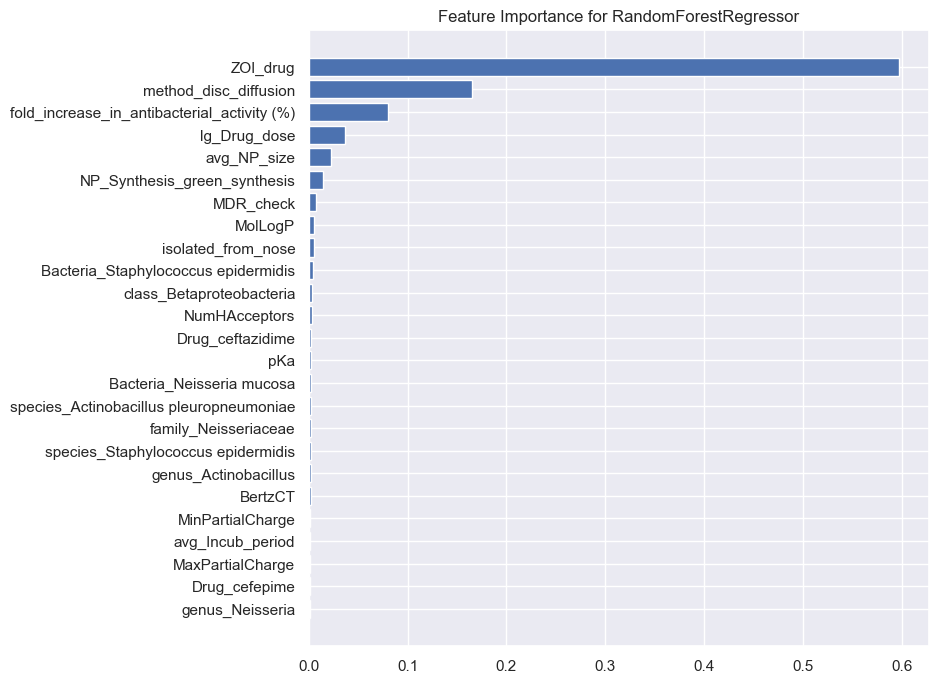

In [70]:
feature_importance = pipe["model"].feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_idx[-25:])), feature_importance[sorted_idx[-25:]], align='center')
plt.yticks(range(len(sorted_idx[-25:])), np.array(X_test.columns)[sorted_idx[-25:]])
plt.title(f'Feature Importance for {pipe["model"].__class__.__name__}');

Скорее всего, это не самый лучший результат, который мы можем получить, не используя нейросетевые модели.
Воспользуемся модулем LazyRegressor, который проверит кучу классических ML-регрессоров с "как правило, хорошими" параметрами и предоставит отчет об их скорах.

In [71]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

for encoded_df, name in zip([df_codes, df_onehot], ['----- df_codes -----\n', '\n\n----- df_onehot -----\n']):
    print(f'{name}')
    X_train, X_test, y_train, y_test = train_test_split(
        encoded_df.drop(columns=['ZOI_drug_NP']), encoded_df['ZOI_drug_NP'], random_state=RANDOM_STATE,
        test_size=0.25    
    )
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models)

----- df_codes -----



100%|██████████| 42/42 [00:05<00:00,  7.98it/s]


                                          Adjusted R-Squared  \
Model                                                          
ExtraTreesRegressor                                     0.82   
GradientBoostingRegressor                               0.77   
BaggingRegressor                                        0.76   
RandomForestRegressor                                   0.75   
XGBRegressor                                            0.74   
HistGradientBoostingRegressor                           0.74   
LGBMRegressor                                           0.73   
ExtraTreeRegressor                                      0.67   
Ridge                                                   0.67   
RidgeCV                                                 0.67   
TransformedTargetRegressor                              0.67   
LinearRegression                                        0.67   
LassoLarsIC                                             0.67   
LassoLarsCV                             

100%|██████████| 42/42 [00:02<00:00, 14.48it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  8.03      -2.20 17.52        0.01
GaussianProcessRegressor                     3.61      -0.19 10.69        0.03
PassiveAggressiveRegressor                   3.54      -0.16 10.54        0.01
QuantileRegressor                            3.30      -0.05 10.03        0.73
DummyRegressor                               3.22      -0.01  9.85        0.01
LinearSVR                                    2.68       0.23  8.57        0.02
RANSACRegressor                              2.67       0.24  8.55        0.08
HuberRegressor                               2.64       0.25  8.45        0.02
PoissonRegressor                             2.60       0.27  8.37        0.01
GammaRegressor                               2.50       0.32  8.08        0.01
TweedieRegressor                             2.40   

Пока что модели ExtraTreeRegressor (одно решающее дерево!) и ExtraTreesRegressor (ансамбль деревьев) лидируют по скору. Между one-hot-encoding и нумерацией классов разница несущественная, и R^2=0.86 

Проверим еще и CatBoost (в LazyPredict его нет). Заодно выясним, какие фичи являются ключевыми в моделях (25 наиболее важных признаков), оставим только их и проверим, насколько подрастёт скор.

In [72]:
def get_scores_by_models(
        models: list, df: pd.DataFrame, random_state=RANDOM_STATE, test_size=0.25, 
        get_features=True, plot_features=False
):
    
    ''' 
    Trains each model in models list, gets their scores and feature importances. Returns 25 best features and prints the scores.

    Parameters
    -----------
    models: list of sklearn.Model objects
        Models to train and test.
    df: pd.DataFrame
        Training data (target column is hardcoded).
    get_features: bool
        Whether to return 25 most important features.
    plot_features: bool
        Whether to plot feature importance histogram
    '''

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['ZOI_drug_NP']), df['ZOI_drug_NP'], random_state=RANDOM_STATE,
        test_size=test_size    
    )
    
    list_best = []

    for model in models:
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        print(f'--- {pipe["model"].__class__.__name__} ---')
        print(f'R2 score: {r2_score(y_test, pred)}')
        print(f'RMSE score: {mean_squared_error(y_test, pred) ** 0.5}')

        if get_features or plot_features:

            feature_importance = pipe["model"].feature_importances_
            sorted_idx = np.argsort(feature_importance)

            if plot_features:
                plt.figure(figsize=(8, 8))
                plt.barh(range(len(sorted_idx[-30:])), feature_importance[sorted_idx[-30:]], align='center')
                plt.yticks(range(len(sorted_idx[-30:])), np.array(X_test.columns)[sorted_idx[-30:]])
                plt.title(f'Feature Importance for {pipe["model"].__class__.__name__}')
            
            best_features = np.array(X_test.columns)[sorted_idx[-30:]]
            list_best.extend(best_features)
        
    return list_best

In [73]:
ex_tree = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)
cat = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)

models = [ex_tree, cat]
features = {}
final_datas = []

df_codes, df_onehot = code_and_onehot(df, cols_to_drop)

for encoded_df, name in zip([df_codes, df_onehot], ['----- df_codes -----\n', '\n\n----- df_onehot -----\n']):
    
    print(f'{name}')
    
    list_best = get_scores_by_models(models, encoded_df)
    
    list_best = list(set(list_best))
    print(f'Amount of important features for two model: {len(list_best)}')
    
    print(f'\nScores after dropping non-important features:')
    
    list_best.append('ZOI_drug_NP')
    encoded_df = encoded_df[list_best]
    final_datas.append(encoded_df)
    
    get_scores_by_models(models, encoded_df)

df_codes_final, df_onehot_final = final_datas
# поскольку после выброса лишних фич, скор упал, оставим df_codes_final c теми же фичами
df_codes_final = df_codes

----- df_codes -----



--- ExtraTreesRegressor ---
R2 score: 0.8677189878858687
RMSE score: 3.5610593618894577
--- CatBoostRegressor ---
R2 score: 0.832755132345293
RMSE score: 4.004117915335764
Amount of important features for two model: 32

Scores after dropping non-important features:
--- ExtraTreesRegressor ---
R2 score: 0.8572686530414952
RMSE score: 3.6990494817500372
--- CatBoostRegressor ---
R2 score: 0.8361843044550017
RMSE score: 3.9628552912173745


----- df_onehot -----

--- ExtraTreesRegressor ---
R2 score: 0.8580397088387755
RMSE score: 3.6890445458565377
--- CatBoostRegressor ---
R2 score: 0.8310167295463091
RMSE score: 4.024874232432742
Amount of important features for two model: 43

Scores after dropping non-important features:
--- ExtraTreesRegressor ---
R2 score: 0.8740660901253585
RMSE score: 3.4745758942108287
--- CatBoostRegressor ---
R2 score: 0.8265430180776963
RMSE score: 4.077804037371322


Если оставлять только самые важные признаки, ExtraTreesRegressor всё равно выигрывает CatBoost, и R^2 вырастает до 0.87.

## GridSearch для лучших моделей

Ищем лучшие наборы параметров для CatBoost и ExtraTreesRegressor

In [74]:
def make_gridsearchCV_by_models(
        models_params: list, 
        df: pd.DataFrame, 
        test_size=0.25, 
        cv=4, 
        random_state=RANDOM_STATE
):
    ''' 
    Trains each model in models list, gets their scores and feature importances. Returns 25 best features and prints the scores.

    Parameters
    -----------
    models_params: list
        List of lists with models and parameters.
    df: pd.DataFrame
        Training data (target column is hardcoded).
    test_size: float default=0.25
        Size of test to train/test split.
    cv: int default=4
        Specify the number of folds
    random_state: int
    '''

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['ZOI_drug_NP']), df['ZOI_drug_NP'], random_state=random_state,
        test_size=test_size    
    )
    
    models = []

    for model in models_params:
        
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model[0])])
        grid = GridSearchCV(pipe, model[1], scoring='r2', n_jobs=-1, cv=cv)
        grid.fit(X_train, y_train)

        print(f'--- Model: {pipe["model"].__class__.__name__} ---\n')
        print(f'Best params: {grid.best_params_}')
        print(f'Best CV R2 score: {grid.best_score_:.3f}')
        print(f'R2 score on unseen data: {r2_score(y_test, grid.best_estimator_.predict(X_test)):.3f}\n')
        
        models.append(grid.best_estimator_['model'])
    
    return models

---- !Следующая ячейка грзуится ~6 минут на AMD Ryzen 5 4600H 3.0 GHz! ---  
(ее можно пропустить и загрузить модели из файла ```best_models.pkl``` в следующей ячейке)

In [75]:
cat = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
cat_params = {
    'model__depth': [1, 2, 3],
    'model__iterations': [500, 1000, 3000, 6000],
    'model__learning_rate': [0.05, 0.1, 0.3, 0.5], 
    'model__l2_leaf_reg': [0.5, 1, 3],
}


ex_tree = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)
tree_params = {
    'model__max_depth': [10, 50, 100],
    'model__n_estimators': [50, 75, 100, 150],
    'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse'], 
    'model__min_samples_split': [2, 3, 4],
}

models_params = [
    [cat, cat_params],
    [ex_tree, tree_params]
]

best_models ={}

for encoded_df, name in zip(
    [df_onehot_final, df_codes_final], 
    ['onehot_final', 'codes_final']
):
    print(f'-- {name} --')
    models = make_gridsearchCV_by_models(models_params, encoded_df, cv=4)
    best_models.update({name: models})

-- onehot_final --


--- Model: CatBoostRegressor ---

Best params: {'model__depth': 3, 'model__iterations': 6000, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.05}
Best CV R2 score: 0.821
R2 score on unseen data: 0.828

--- Model: ExtraTreesRegressor ---

Best params: {'model__criterion': 'absolute_error', 'model__max_depth': 50, 'model__min_samples_split': 3, 'model__n_estimators': 75}
Best CV R2 score: 0.819
R2 score on unseen data: 0.855

-- codes_final --
--- Model: CatBoostRegressor ---

Best params: {'model__depth': 2, 'model__iterations': 6000, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1}
Best CV R2 score: 0.824
R2 score on unseen data: 0.851

--- Model: ExtraTreesRegressor ---

Best params: {'model__criterion': 'absolute_error', 'model__max_depth': 50, 'model__min_samples_split': 3, 'model__n_estimators': 150}
Best CV R2 score: 0.832
R2 score on unseen data: 0.852



Смотрим на лучшие наборы параметров. Первый элемент списка - для кодирования one-hot, второй - для кат. фичей номерами.

In [76]:
# pickle.dump(best_models, open('best_models.pkl', 'wb'))
# best_models = pickle.load(open('best_models.pkl', 'rb'))
best_models

{'onehot_final': [<catboost.core.CatBoostRegressor at 0x12f9328d4b0>,
  ExtraTreesRegressor(criterion='absolute_error', max_depth=50,
                      min_samples_split=3, n_estimators=75, n_jobs=-1,
                      random_state=42)],
 'codes_final': [<catboost.core.CatBoostRegressor at 0x12f9171d930>,
  ExtraTreesRegressor(criterion='absolute_error', max_depth=50,
                      min_samples_split=3, n_estimators=150, n_jobs=-1,
                      random_state=42)]}

Попробуем применить голосование (VotingRegressor) для CatBoost и ExtraTreesRegressor и посмотрим его качество на кросс-валидации

In [77]:
for group_models, encoded_df, name in zip(
    best_models.values(), 
    [df_onehot_final, df_codes_final], 
    ['---- df_onehot_final ----\n', '\n\n---- df_codes_final ----\n']
):
    
    print(name)
    X, y = shuffle(
        encoded_df.drop(columns=['ZOI_drug_NP']), encoded_df['ZOI_drug_NP'], 
        random_state=RANDOM_STATE
    )

    vot = VotingRegressor([('cat', group_models[0]), ('ex_tree', group_models[1])], n_jobs=-1)
    pipe = Pipeline([('scaler', StandardScaler()), ('model',vot)])
    score = cross_val_score(
        pipe, X, y,
        cv=4, scoring='r2'
    )
    
    print(f'R2 score: {score.mean():.3f} with a standard deviation {score.std():.3f}')
    print(f'R2 score max: {score.max():.3f}')

---- df_onehot_final ----



R2 score: 0.829 with a standard deviation 0.021
R2 score max: 0.850


---- df_codes_final ----

R2 score: 0.839 with a standard deviation 0.025
R2 score max: 0.861


Score на df_code получился на 1% выше (и в целом прирост в точности, в сравнении с одельными моделями), дальше будем использовать именно этот датасет \
Отобразим кривые обучения всего ансамбля и выбранные фичи для каждой модели внутри

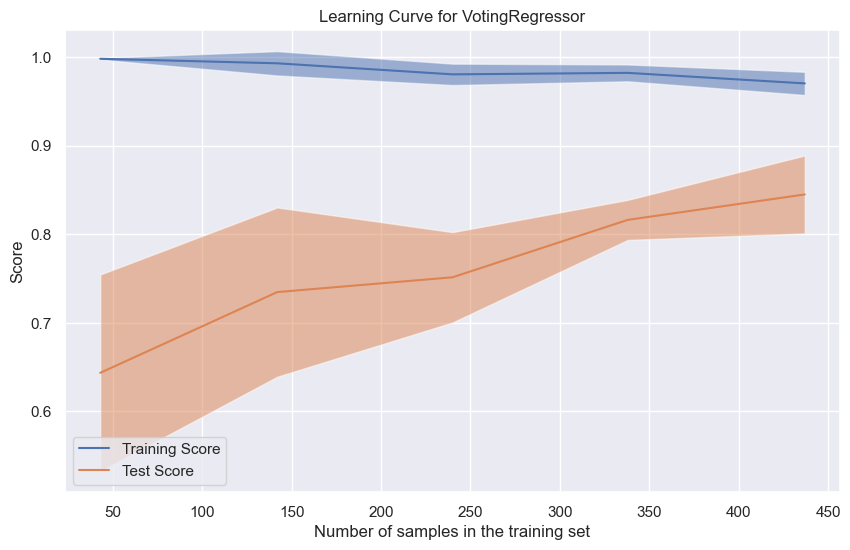

In [78]:
# Визуализация работы VotingRegressor на лучших моделях с помощью LearningCurveDisplay
X, y = df_codes_final.drop(columns=['ZOI_drug_NP']), df_codes_final['ZOI_drug_NP']
X, y = shuffle(X, y, random_state=RANDOM_STATE)

fig, ax = plt.subplots(figsize=(10, 6))
pipe = Pipeline([('scaler', StandardScaler()), ('model', vot)])
LearningCurveDisplay.from_estimator(
    pipe, X=X, y=y,
    ax=ax, n_jobs=-1, 
)

handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {pipe['model'].__class__.__name__}");

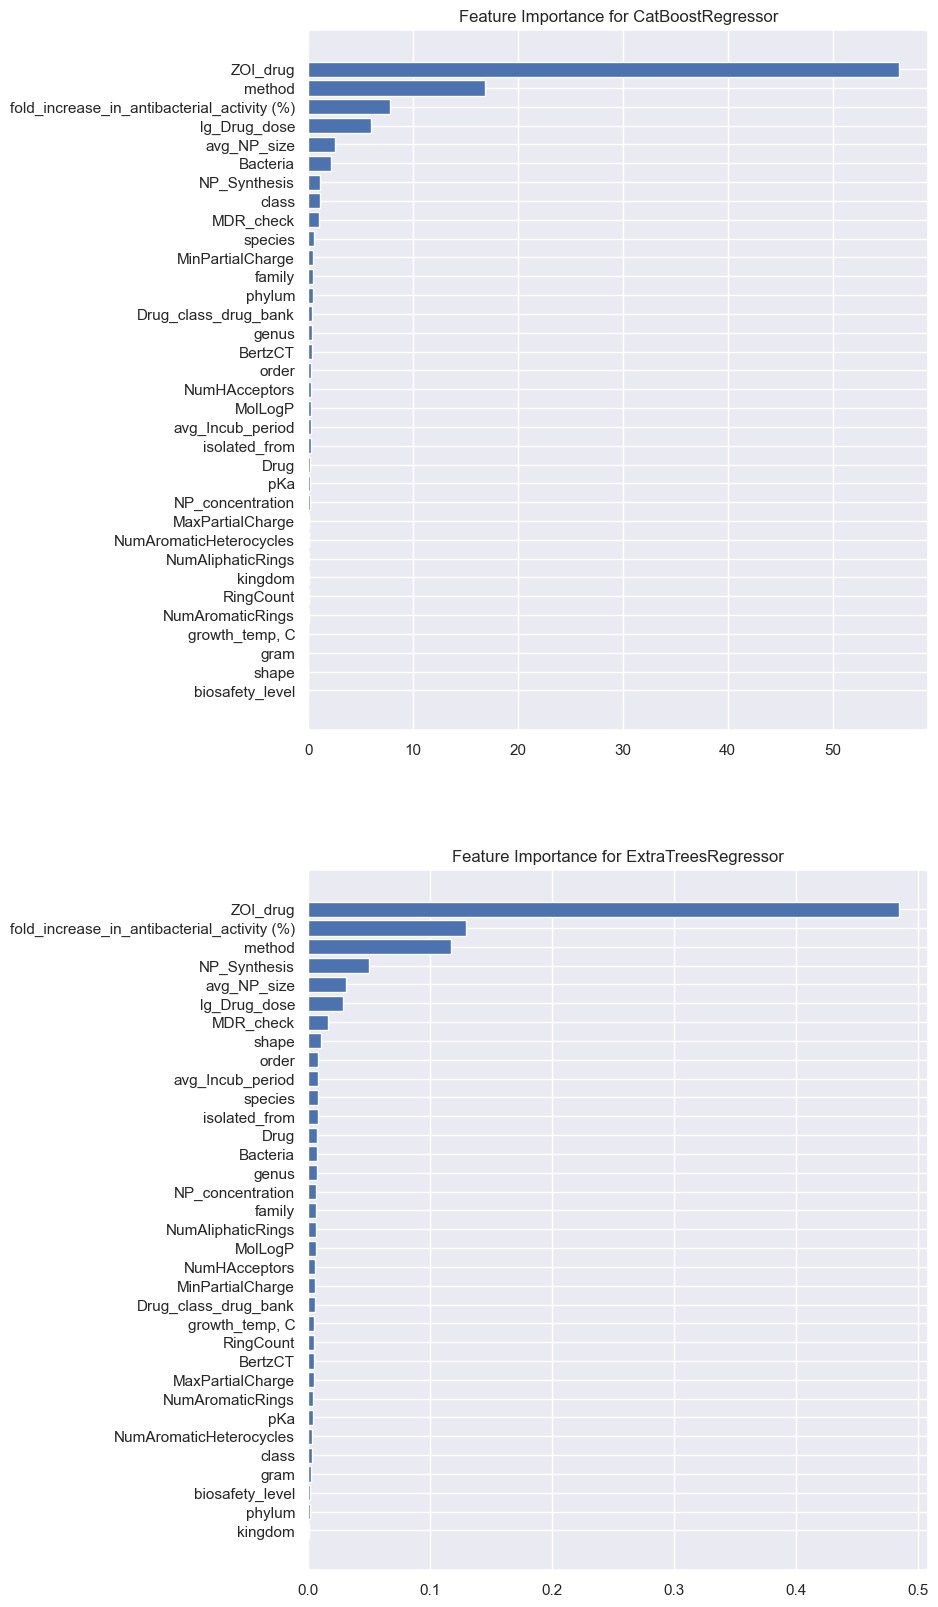

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(8, 20))

for i, model in enumerate(pipe['model'].estimators):
    model = model[1]
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    ax[i].barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    ax[i].set_yticks(range(len(sorted_idx)), minor=False)
    ax[i].set_yticklabels(np.array(X.columns)[sorted_idx])
    ax[i].set_title(f'Feature Importance for {model.__class__.__name__}')
    

## Подготовка моделей

Подготовим модель, обученную на датасете с categorical codes encoding для дальнейших предсказаний

In [80]:
best_models = best_models['codes_final']

vot = VotingRegressor([('cat', best_models[0]), ('ex_tree', best_models[1])], n_jobs=-1)
best_models.append(vot)

X, y = shuffle(
    df_codes_final.drop(columns=['ZOI_drug_NP']), df_codes_final['ZOI_drug_NP'], 
    random_state=RANDOM_STATE
)

models_to_pack = {}

for model in best_models:
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipe.fit(X, y)
    model = pipe['model']
    models_to_pack.update(
        {model.__class__.__name__: pipe}
    )

# выкидываем ZOI_drug_NP т.к. это таргет
models_to_pack.update({'features': df_codes_final.drop(columns=['ZOI_drug_NP']).columns})
pickle.dump(models_to_pack, open('fitted_models.pkl', 'wb'))

Для использования моделей см. файл predict.ipynb

# 9 | Обучаем нейросеть
Для этой задачи мы построим полносвязную нейронную сеть на PyTorch. Особо перебирать архитектуру не будем, пара заметок - не нужно делать очень уж глубокую сеть, поскольку датасет маленький: если будет адекватный скор - уже хорошо.

## Загрузка и предобработка данных

In [197]:
df = df_nn

X = torch.tensor(df.drop(columns=['ZOI_drug_NP']).astype('float32').to_numpy())
y = torch.tensor(df['ZOI_drug_NP'].astype('float32').to_numpy().reshape(-1, 1))

Данные нужно отмасштабировать, чтобы градиенты не взрывались

In [198]:
scaler = MinMaxScaler()
scaler.fit_transform(X, y)

array([[2.22222222e-01, 5.96745060e-02, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 5.96745060e-02, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 4.21338158e-01, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [2.22222222e-01, 5.96745060e-02, 4.68749990e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 4.21338158e-01, 4.68749990e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 1.00000000e+00, 3.90625000e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

Делим на тест и трейн

In [145]:
'''X, X_test, y, y_test = train_test_split(X, y, test_size=0.07)
print(f'Train: {X.shape[0]}, test: {X_test.shape[0]}')
print(f'Features: {X.shape[1]}')'''

"X, X_test, y, y_test = train_test_split(X, y, test_size=0.07)\nprint(f'Train: {X.shape[0]}, test: {X_test.shape[0]}')\nprint(f'Features: {X.shape[1]}')"

А это генератор рандомного разделения для гридсёрча

## Модель

Попробуем небольшую модель с одним скрытым слоем, в котором нейронов будет втрое меньше, чем на входе. После входного и скрытого слоев будет функция активации: по дефолту поставим ReLU(x) = max(0, x), а потом подберем лучшую.

Дропаут - это защита от переобучения. При применении дропаута ```0 <= w * 100% <= 100%``` нейронов деактивируется, ```w``` - аргумент ```nn.Dropout()```. Сначала исследуем модель без него, лучшие параметры применим для модели с дропаутом. 

In [206]:
class DenseNN(nn.Module):
    def __init__(self, in_features: int, activation=F.relu, do_dropout=False):
        super(DenseNN, self).__init__()
        self.activation = activation
        self.fc1 = nn.Linear(in_features, in_features)
        self.fc2 = nn.Linear(in_features, in_features)
        self.fc3 = nn.Linear(in_features , 1)
        self.do_dropout = do_dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.activation(self.fc1(x))

        if self.do_dropout:
            x = self.dropout(x)

        x = self.activation(self.fc2(x))
        
        if self.do_dropout:
            x = self.dropout(x)        
        
        x = self.fc3(x)
        return x

## Обучаем модель

Лосс - MSE как стандарт для регрессии, оптимизация Adam либо SGD

### Без CV

In [138]:
def test_model(loss_fn_name=nn.MSELoss, 
               optimizer_lr=(torch.optim.Adam, 3e-4),
               n_epochs=75,
               batch_size=6,
               activation_name=F.relu,
               do_dropout=False,
               verbose=True):
    ''' 
    Performs DenseNN model training, including r2-scoring on test data every epoch 
    Parameters are obvious
    
    Returns
    -------
    (model, history_loss, history_r2): tuple of DenseNN(nn.Module), list, list
        Trained model, loss and r2 scores for each epoch 
    '''

    model = DenseNN(X.shape[1], activation=activation_name, do_dropout=do_dropout)
    
    loss_fn = loss_fn_name()
    optimizer = optimizer_lr[0](model.parameters(), lr=optimizer_lr[1])

    history_loss = []
    history_r2 = []

    for n_epoch in range(n_epochs):

        model.train()

        for i in range(0, len(X), batch_size):
            Xbatch = X[i:i+batch_size]
            
            y_pred = model(Xbatch)
        
            ybatch = y[i:i+batch_size]

            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()

        history_loss.append(loss.item())
        history_r2.append(r2_score(y_test.detach().numpy(), model(X_test).detach().numpy()))
        
        if verbose:
            print(f'Finished epoch {n_epoch + 1}/{n_epochs}, latest loss {history_loss[-1]:.3f}, R^2 on test {history_r2[-1]:.3f}')

    return model, history_loss, history_r2

Finished epoch 1/75, latest loss 108.056, R^2 on test -0.777
Finished epoch 2/75, latest loss 58.308, R^2 on test -0.276
Finished epoch 3/75, latest loss 28.614, R^2 on test -0.037
Finished epoch 4/75, latest loss 15.838, R^2 on test 0.112
Finished epoch 5/75, latest loss 10.515, R^2 on test 0.220
Finished epoch 6/75, latest loss 8.173, R^2 on test 0.302
Finished epoch 7/75, latest loss 6.419, R^2 on test 0.348
Finished epoch 8/75, latest loss 5.544, R^2 on test 0.393
Finished epoch 9/75, latest loss 4.853, R^2 on test 0.424
Finished epoch 10/75, latest loss 4.283, R^2 on test 0.444
Finished epoch 11/75, latest loss 3.874, R^2 on test 0.452
Finished epoch 12/75, latest loss 3.249, R^2 on test 0.456
Finished epoch 13/75, latest loss 2.880, R^2 on test 0.465
Finished epoch 14/75, latest loss 2.593, R^2 on test 0.471
Finished epoch 15/75, latest loss 2.418, R^2 on test 0.477
Finished epoch 16/75, latest loss 2.326, R^2 on test 0.484
Finished epoch 17/75, latest loss 2.301, R^2 on test 0.4

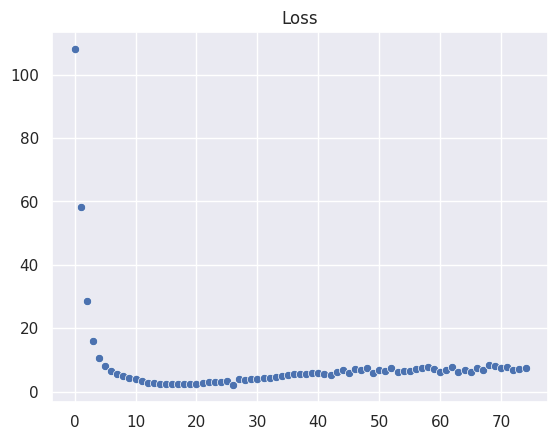

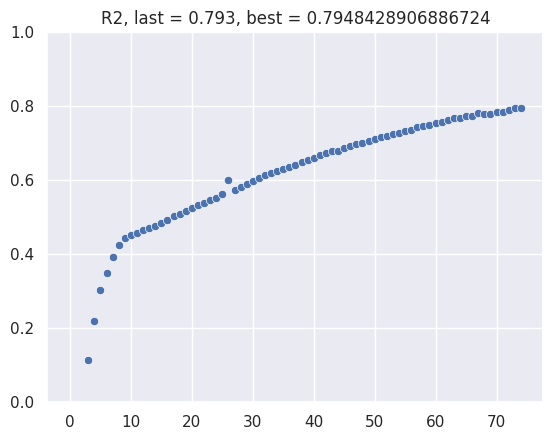

In [139]:
model, history_loss, history_r2 = test_model()

sns.scatterplot(history_loss)
plt.title('Loss')
plt.show()
sns.scatterplot(history_r2)
plt.title(f'R2, last = {round(r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()), 3)}, best = {max(history_r2)}')
plt.ylim(0, 1)
plt.show()

### С CV

In [207]:
def test_model_CV(X=X, 
                  y=y,
                  folds=5,
                  loss_fn_name=nn.MSELoss,
                  optimizer_lr=(torch.optim.Adam, 3e-4),
                  n_epochs=75,
                  batch_size=6,
                  activation_name=F.relu,
                  do_dropout=False,
                  verbose=True,
                  plot_results=True):
    ''' 
    Performs DenseNN model training using CV, including r2-scoring on test data every epoch 
    Parameters:
    -----------
    X, y: torch.tensors (dtype float32)
        All data, not train_test_splitted
    folds: int
        Number of folds for cross validation. Splitting proportion is round(1/folds, 2) for test
    loss_fn_name: torch.nn.Module
        Class of loss function
    optimizer_lr: tuple(torch.nn.Module, float)
        Class of optimizer and learning rate parameter
    n_epochs: int
    batch_size: int
    activation_name: torch.nn.Module or function
        Activation function class or function
    do_dropout: bool
    verbose: bool
        Whether to print training data every epoch
    plot_results: bool
    
    Returns
    -------
    (model, history_loss, history_r2): tuple of DenseNN(nn.Module), list, list
        Trained model with best r2 score, loss and r2 scores for each epoch  for this model.
    '''

    folds_history_max_r2 = []
    folds_history_r2 = []
    folds_history_loss = []
    models = []

    for n_fold in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1/folds, 2))
        
        if verbose:
            print(f'\n ------------------- \nFold {n_fold+1}')
            print(f'Train: {X_train.shape[0]}, test: {X_test.shape[0]}')
            print(f'Features: {X_train.shape[1]}')

        model = DenseNN(X_train.shape[1], activation=activation_name, do_dropout=do_dropout)
        loss_fn = loss_fn_name()
        optimizer = optimizer_lr[0](model.parameters(), lr=optimizer_lr[1])

        history_loss = []
        history_r2 = []

        for n_epoch in range(n_epochs):

            model.train()

            for i in range(0, len(X_train), batch_size):
                Xbatch = X_train[i:i+batch_size]
                
                y_pred = model(Xbatch)
            
                ybatch = y_train[i:i+batch_size]

                loss = loss_fn(y_pred, ybatch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            model.eval()

            history_loss.append(loss.item())
            history_r2.append(r2_score(y_test.detach().numpy(), model(X_test).detach().numpy()))
            
            if verbose:
                print(f'Finished epoch {n_epoch + 1}/{n_epochs}, latest loss {history_loss[-1]:.3f}, R^2 on test {history_r2[-1]:.3f}')
        if verbose:
            print(f'Finished training, max R2 = {max(history_r2)}')

        folds_history_r2.append(history_r2)
        folds_history_loss.append(history_loss)
        folds_history_max_r2.append(max(history_r2))
        models.append(deepcopy(model))

    print(f'CV training finished. Average R2: {sum(folds_history_max_r2)/folds:.3f}')

    x_points = []
    if plot_results:
        x_points = list(range(1, n_epochs+1))
        for n_fold, hist in enumerate(folds_history_r2):
            plt.plot(x_points, hist, label=f"fold {n_fold+1}")
        plt.legend()
        plt.title(f'R2, best = {max(folds_history_max_r2):.3f}')
        plt.show()

        plt.clf()

        for n_fold, hist in enumerate(folds_history_loss):
            plt.plot(x_points, hist, label=f"fold {n_fold+1}")
        plt.legend()
        plt.title(f'loss')
        plt.show()
        
        

    return             (models[folds_history_max_r2.index(max(folds_history_max_r2))], 
            folds_history_loss[folds_history_max_r2.index(max(folds_history_max_r2))], 
              folds_history_r2[folds_history_max_r2.index(max(folds_history_max_r2))])

CV training finished. Average R2: 0.573


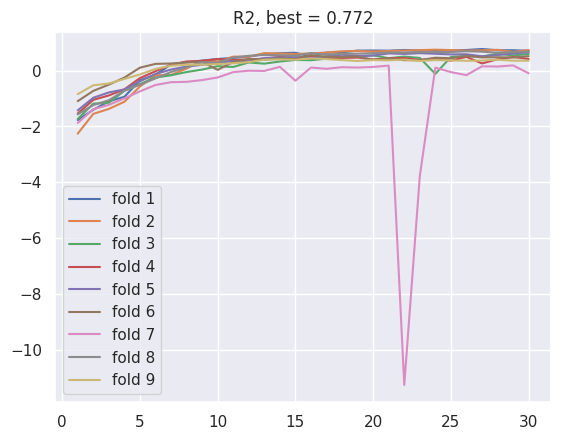

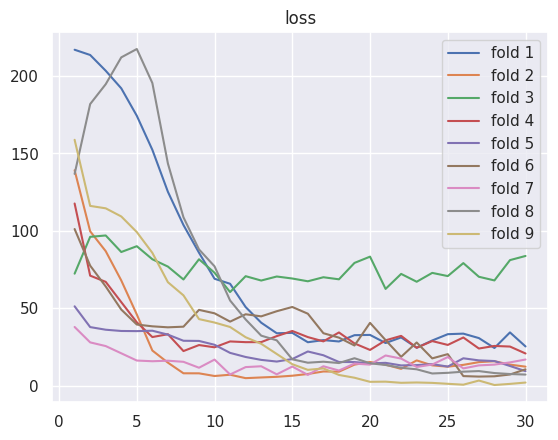

In [205]:
model, _, _ = test_model_CV(activation_name=F.leaky_relu, 
              folds=9,
              do_dropout=True,
              n_epochs=200,              
              verbose=False)

## Подбор лучших параметров
Сделаем простейший гридсёрч с помощью итератора

In [178]:
def get_params(param_list_1, param_list_2=None, param_list_3=None, param_list_4=None, param_list_5=None):
    ''' 
    Parameters:
    -----------
    param_list_i: list
        Parameters to choose from. If unset or None, not used in grid

    Yields:
    -----------
    (param_1, param_2, ...): tuple, len = 5

    '''
    
    for param_1 in param_list_1:
        if param_list_2:
            for param_2 in param_list_2:
                if param_list_3:
                    for param_3 in param_list_3:
                        if param_list_4:
                            for param_4 in param_list_4:
                                if param_list_5:
                                    for param_5 in param_list_5:
                                        yield param_1, param_2, param_3, param_4, param_5
                                else:
                                    yield param_1, param_2, param_3, param_4, None
                        else:
                            yield param_1, param_2, param_3, None, None
                else:
                    yield param_1, param_2, None, None, None
        else:
            yield param_1, None, None, None, None

CV training finished. Average R2: 0.619


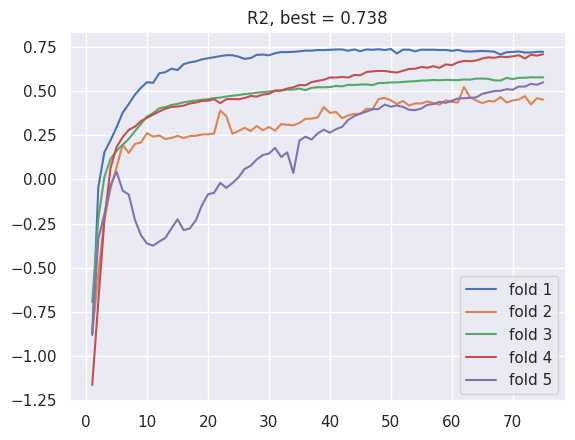

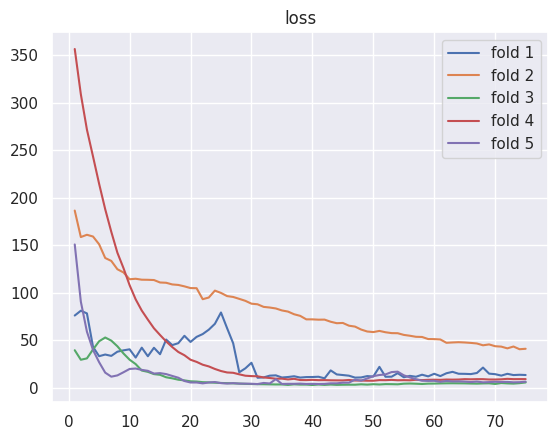

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 75
          
Max R2: 0.7379379062849143, last R2: 0.7223078601151673
CV training finished. Average R2: 0.716


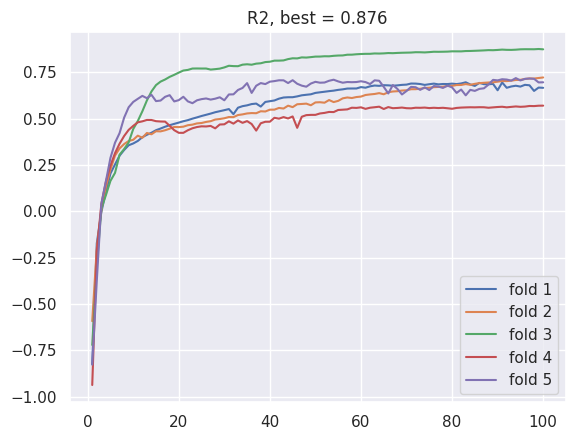

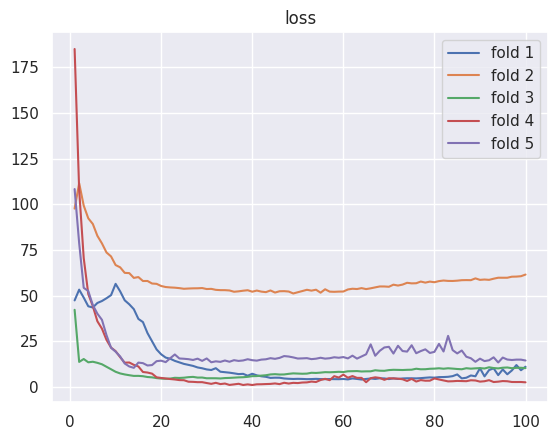

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 100
          
Max R2: 0.8756443939264529, last R2: 0.8739414229324434
CV training finished. Average R2: 0.711


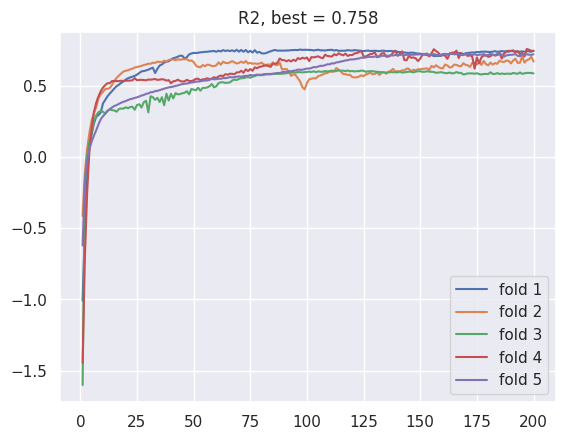

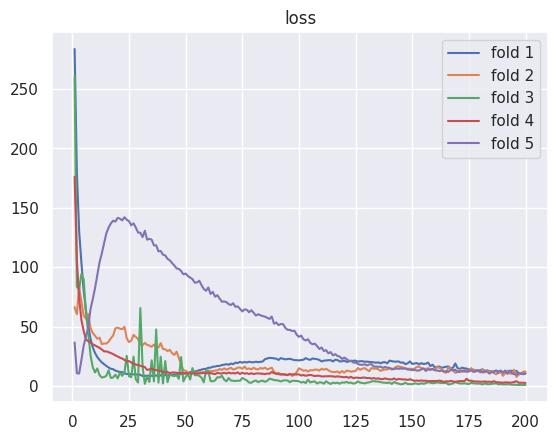

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 200
          
Max R2: 0.7584954628080074, last R2: 0.7440982782027628
CV training finished. Average R2: 0.724


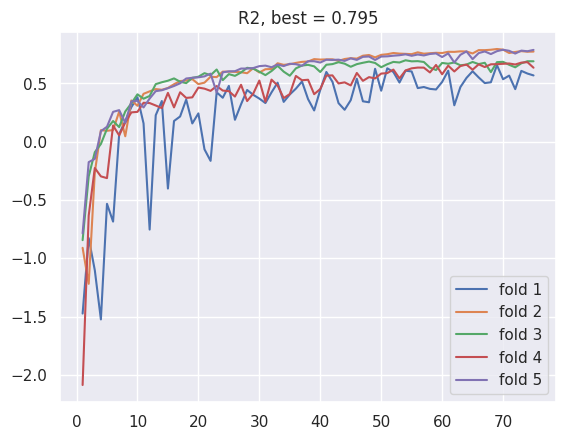

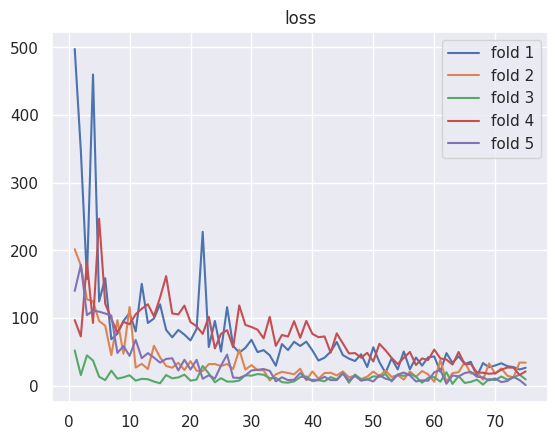

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... True,
                epochs .......... 75
          
Max R2: 0.7953179325893438, last R2: 0.7732094556167027
CV training finished. Average R2: 0.790


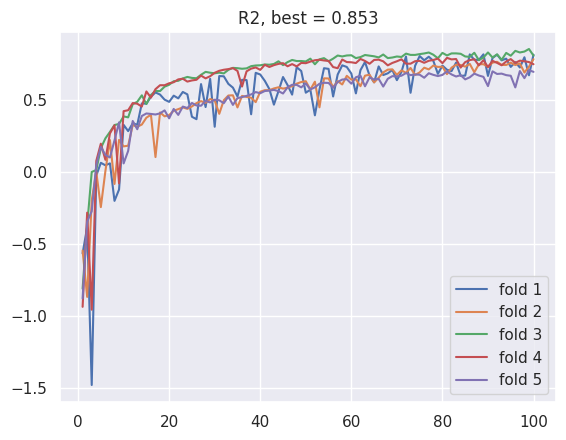

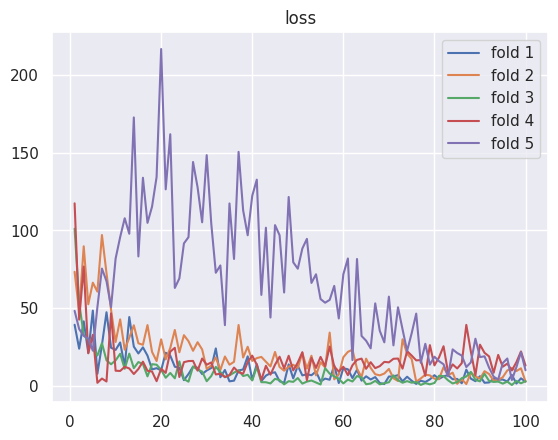

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... True,
                epochs .......... 100
          
Max R2: 0.8530727995363302, last R2: 0.8071176307732304
CV training finished. Average R2: 0.762


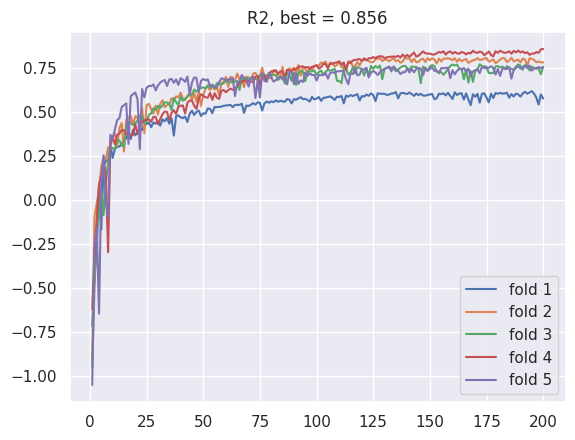

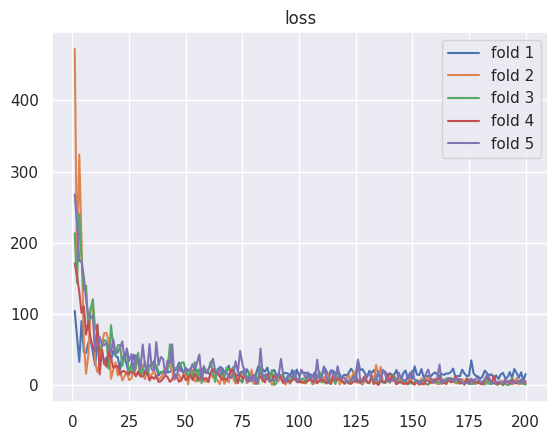

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... True,
                epochs .......... 200
          
Max R2: 0.855558909900968, last R2: 0.855558909900968
CV training finished. Average R2: 0.721


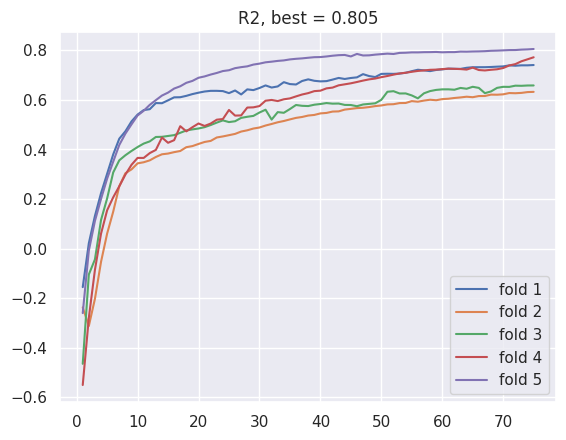

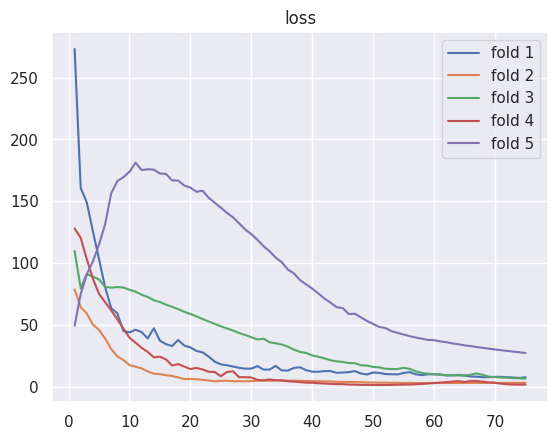

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... elu,
                do dropout ...... False,
                epochs .......... 75
          
Max R2: 0.8049893677871311, last R2: 0.8049893677871311
CV training finished. Average R2: 0.729


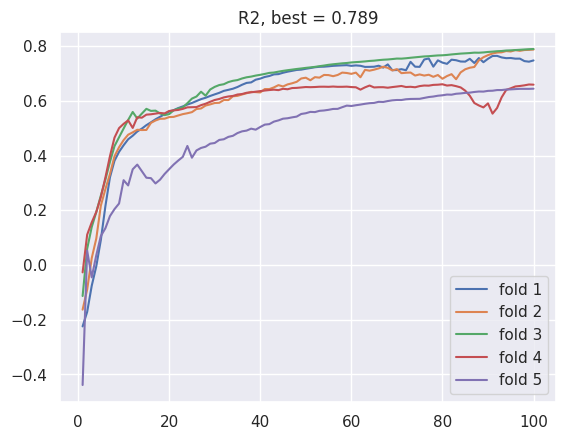

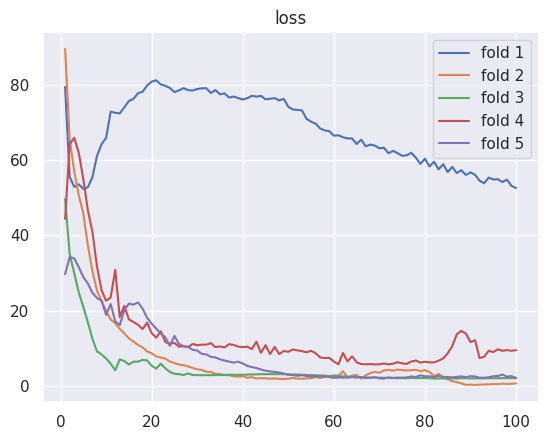

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... elu,
                do dropout ...... False,
                epochs .......... 100
          
Max R2: 0.7891033362618761, last R2: 0.7891033362618761
CV training finished. Average R2: 0.826


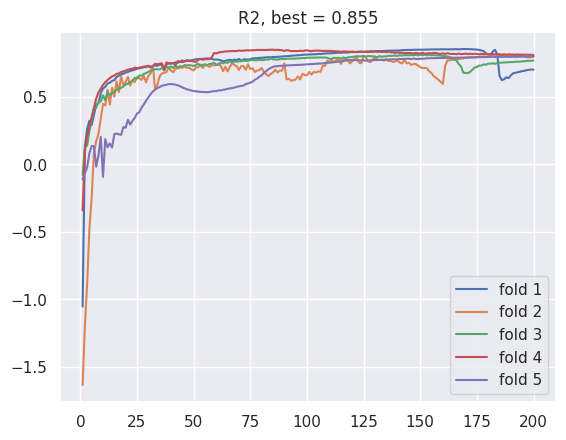

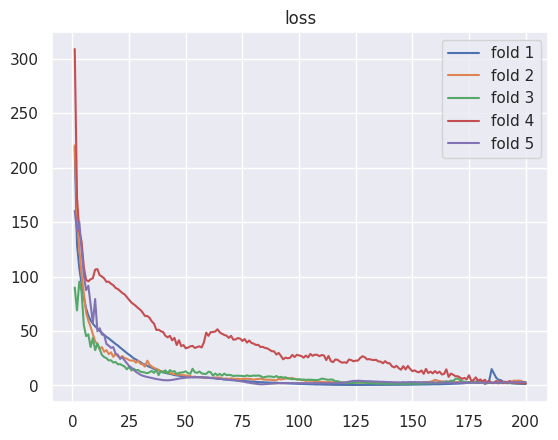

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... elu,
                do dropout ...... False,
                epochs .......... 200
          
Max R2: 0.8547693524526881, last R2: 0.7017146512630819
CV training finished. Average R2: 0.659


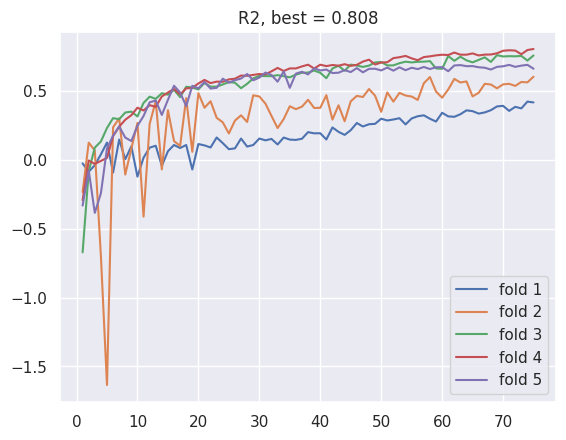

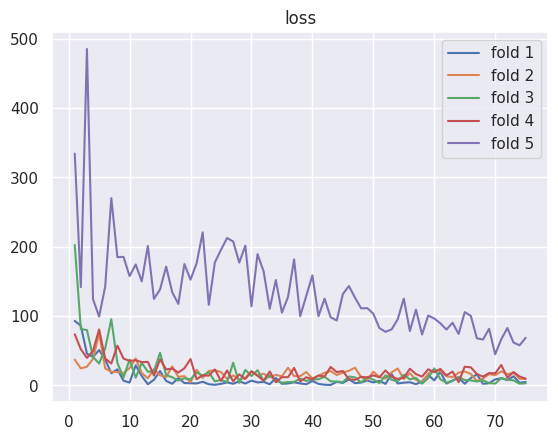

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... elu,
                do dropout ...... True,
                epochs .......... 75
          
Max R2: 0.8077897285548842, last R2: 0.8077897285548842
CV training finished. Average R2: 0.779


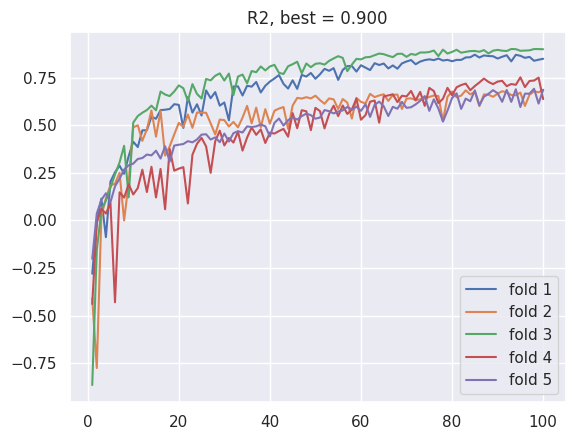

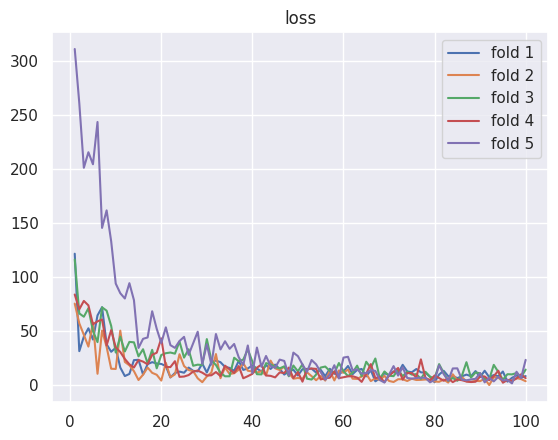

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... elu,
                do dropout ...... True,
                epochs .......... 100
          
Max R2: 0.8997424563460173, last R2: 0.898462048982367
CV training finished. Average R2: 0.782


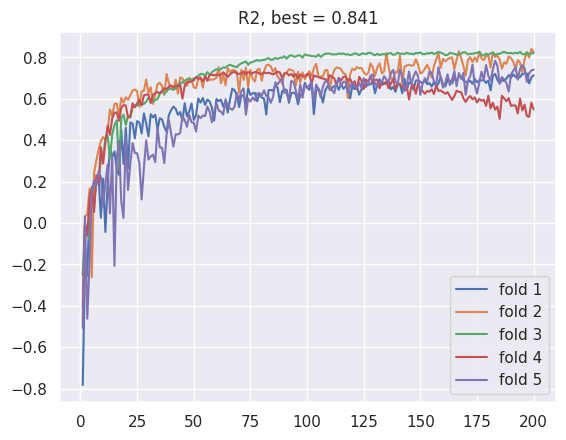

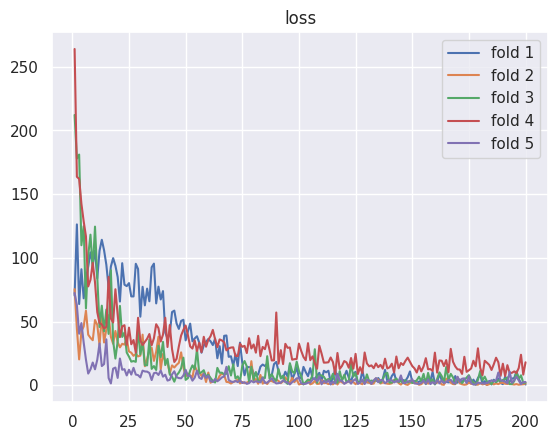

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... elu,
                do dropout ...... True,
                epochs .......... 200
          
Max R2: 0.840992596493305, last R2: 0.8276155072018538
CV training finished. Average R2: 0.680


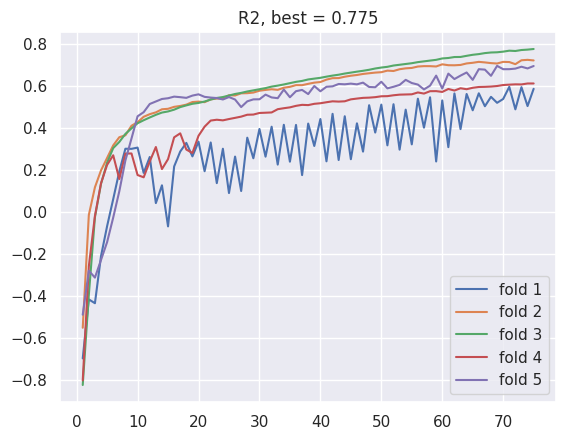

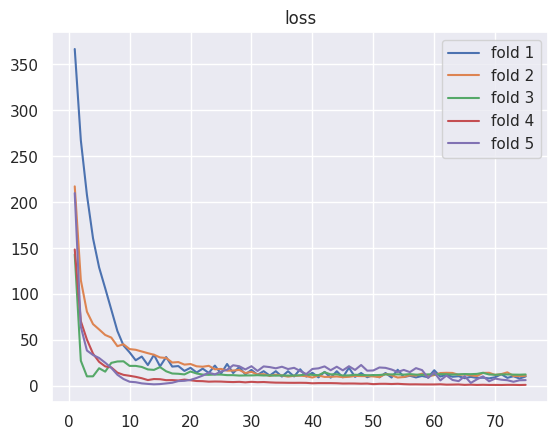

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... leaky_relu,
                do dropout ...... False,
                epochs .......... 75
          
Max R2: 0.7749241766596606, last R2: 0.7749241766596606


KeyboardInterrupt: 

In [179]:
optimizers = [(torch.optim.Adam, 3e-4)]
activations = [F.relu, F.elu, F.leaky_relu]
dropout_modes = [False, True]
ns_epochs = [75, 100, 200]

for optimizer, activation, dropout_mode, n_epochs, _ in get_params(optimizers, activations, dropout_modes, ns_epochs):
    print('-------------------------')
    model, history_loss, history_r2 = test_model_CV(optimizer_lr=optimizer, 
                                                 n_epochs=n_epochs, 
                                                 activation_name=activation, 
                                                 do_dropout=dropout_mode,
                                                 verbose=False)

    print(f'''Params:
                optimizer ....... {optimizer[0].__name__},
                activation ...... {activation.__name__},
                do dropout ...... {dropout_mode},
                epochs .......... {n_epochs}
          ''')
    print(f'Max R2: {max(history_r2)}, last R2: {history_r2[-1]}')

SGD медленно обучается, а при повышении lr градиенты взрывались. Глобально модель очень чувствительна к lr (и random_state🤣)

Лучшие параметры:
Adam, elu, с дропаутом, чуть меньше чем 200 эпох. ```R^2 = 0.9125``` !!!!!

Finished epoch 1/230, latest loss 191.843, R^2 on test -0.937
Finished epoch 2/230, latest loss 112.364, R^2 on test -0.504
Finished epoch 3/230, latest loss 166.555, R^2 on test -0.218
Finished epoch 4/230, latest loss 107.298, R^2 on test -0.436
Finished epoch 5/230, latest loss 110.956, R^2 on test -0.133
Finished epoch 6/230, latest loss 86.994, R^2 on test -0.328
Finished epoch 7/230, latest loss 73.012, R^2 on test -0.245
Finished epoch 8/230, latest loss 36.216, R^2 on test 0.081
Finished epoch 9/230, latest loss 40.505, R^2 on test -0.162
Finished epoch 10/230, latest loss 22.918, R^2 on test 0.101
Finished epoch 11/230, latest loss 73.784, R^2 on test 0.041
Finished epoch 12/230, latest loss 37.302, R^2 on test 0.009
Finished epoch 13/230, latest loss 50.067, R^2 on test 0.127
Finished epoch 14/230, latest loss 21.388, R^2 on test 0.076
Finished epoch 15/230, latest loss 29.909, R^2 on test 0.198
Finished epoch 16/230, latest loss 61.094, R^2 on test 0.228
Finished epoch 17/23

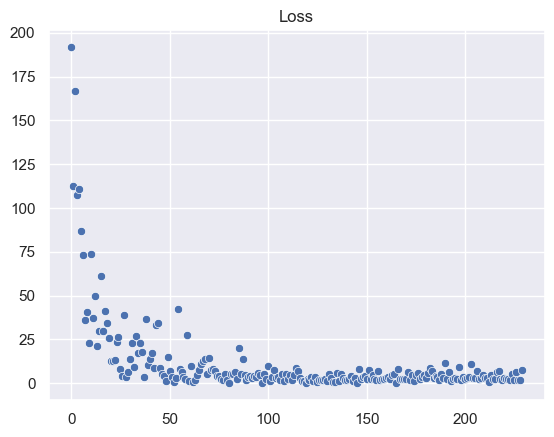

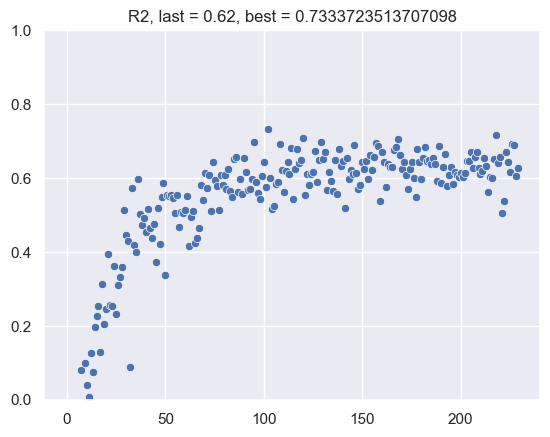

In [108]:
model, history_loss, history_r2 = test_model(optimizer_lr=(torch.optim.Adam, 1.2e-4), 
                                                 n_epochs=230, 
                                                 activation_name=F.elu, 
                                                 do_dropout=True,
                                                 verbose=True)

sns.scatterplot(history_loss)
plt.title('Loss')
plt.show()
sns.scatterplot(history_r2)
plt.title(f'R2, last = {round(r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()), 3)}, best = {max(history_r2)}')
plt.ylim(0, 1)
plt.show()